# Fig. 1 MPSA Analysis


In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm
import re
import mplcursors  # for interactive plotting
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

# My functions
import utils

# Useful variables
e = np.exp(1)
idx = pd.IndexSlice
_ = np.newaxis

# For displaying figures
%matplotlib inline

In [2]:
# Define plot style
style_file_name = 'fig.style'
s = """
axes.linewidth:     1.0     # edge linewidth
font.size:          7.0  
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0  # fontsize of the titles
xtick.labelsize:    7.0  # fontsize of the xtick labels
ytick.labelsize:    7.0  # fontsize of the ytick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
figure.dpi: 600
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# Remove all .pdf files
#!rm *.pdf

# Load data

In [4]:
# Set known motifs
wt_motif   = 'AGGA/GUAAGU'
cons_motif = 'NCAG/GUAAGU'
null_motif = 'NCAG/GGAAGA'

In [5]:
# Load all data
# Normalize by median of consensus sequences

from scipy import stats

# Set file names
filenames = ['psi_smn2_dmso.csv',
             'psi_smn2_rg.csv',
             'psi_smn2_nvs.csv']
filenames = ['../data/mpsa/'+f for f in filenames]
y_cols = ['smn2_dmso', 'smn2_rg', 'smn2_nvs']
dy_cols = [col+'_log_std' for col in y_cols]

# Set a minimal PSI below which we clip
min_psi = 1E-2

# Load SMN2 data
for i, filename in enumerate(filenames):
    col = filename.split('/')[-1].split('.')[0][4:]
    tmp_df = pd.read_csv(filename, sep=',')

    # Rename splice sites
    tmp_df['ss'] = [s.replace('T','U') for s in tmp_df['ss']]
    tmp_df['ss'] = [s[:4]+'/'+s[4:] for s in tmp_df['ss']]
    tmp_df = tmp_df.set_index('ss')

    # Normalize each replicate by the median PSI of the 4 consensus sequences
    cons_ix = utils.motif_to_ix(cons_motif, tmp_df.index)
    cons_psi = tmp_df[cons_ix].median(axis=0)
    tmp_df.loc[:,:] = 100*tmp_df.values/cons_psi.values
    
    # Make header
    if i==0:
        smn2_df = pd.DataFrame(index=tmp_df.index)
    
    # Take median PSIs across columns
    smn2_df[col] = tmp_df.median(axis=1)
    
    # Create mask
    psis = tmp_df.values
    mask = tmp_df >= min_psi
    num_cols = tmp_df.shape[1]
    std_log = np.std(np.log(psis), where=mask, axis=1)
    num_entries = np.sum(mask, axis=1)
    smn2_df[col+'_log_std'] = std_log/np.sqrt(num_entries)    
        
# Normalize AGAIN by median PSI
cons_ix = utils.motif_to_ix(cons_motif, smn2_df.index)
cons_psi = smn2_df[cons_ix][y_cols].median(axis=0)
smn2_df.loc[:,y_cols] = 100*smn2_df.loc[:,y_cols].values/cons_psi.values
#smn2_df.loc[:,dy_cols] = 100*smn2_df.loc[:,dy_cols].values/cons_psi.values

# Verify that median PSI of consensus sequences is 100.0
cons_ix = utils.motif_to_ix(cons_motif, smn2_df.index)
#assert(np.all(smn2_df[cons_ix].median(axis=0) == 100))

# Set sequences
seqs = smn2_df.index.values

# Set known motif indices and view quantities
wt_ix = utils.motif_to_ix(wt_motif, seqs)
cons_ix     = utils.motif_to_ix(cons_motif, seqs) 
null_ix     = utils.motif_to_ix(null_motif, seqs)

print(f'Num wildtype seqs: {sum(wt_ix)} ')
print(f'Num cons seqs: {sum(cons_ix)} ')
print(f'Num null seqs: {sum(null_ix)} ')

print(f'N: {len(smn2_df)}')
smn2_df.head()

Num wildtype seqs: 1 
Num cons seqs: 4 
Num null seqs: 4 
N: 285


/var/folders/20/m6rbxnjn0zq40r2bn1x6f5x80000gn/T/ipykernel_74195/1820852665.py:43: RuntimeWarning: divide by zero encountered in log
  std_log = np.std(np.log(psis), where=mask, axis=1)
/var/folders/20/m6rbxnjn0zq40r2bn1x6f5x80000gn/T/ipykernel_74195/1820852665.py:43: RuntimeWarning: divide by zero encountered in log
  std_log = np.std(np.log(psis), where=mask, axis=1)
/var/folders/20/m6rbxnjn0zq40r2bn1x6f5x80000gn/T/ipykernel_74195/1820852665.py:43: RuntimeWarning: divide by zero encountered in log
  std_log = np.std(np.log(psis), where=mask, axis=1)


smn2_dmso  smn2_dmso_log_std    smn2_rg  smn2_rg_log_std  \
ss                                                                      
AAAA/GUAAGU  94.816183           0.038251  74.969468         0.043137   
AACA/GUAAGU  86.257933           0.043625  72.047758         0.056629   
AAGA/GUAAAU   0.119696           0.279578   0.000000         0.533347   
AAGA/GUAACU   0.208651           0.125712   0.000000         0.479768   
AAGA/GUAAGA   0.496079           0.270210  23.553215         0.141298   

              smn2_nvs  smn2_nvs_log_std  
ss                                        
AAAA/GUAAGU  81.631149          0.056442  
AACA/GUAAGU  90.199186          0.064540  
AAGA/GUAAAU   0.384295          0.314739  
AAGA/GUAACU   0.209434          0.237570  
AAGA/GUAAGA  76.988843          0.059458

In [6]:
mask

smn2_select_lib1_rep1  smn2_select_lib1_rep2  \
ss                                                          
AAAA/GUAAGU                   True                   True   
AACA/GUAAGU                   True                   True   
AAGA/GUAAAU                   True                   True   
AAGA/GUAACU                   True                   True   
AAGA/GUAAGA                   True                   True   
...                            ...                    ...   
UGGC/GUAAGU                   True                   True   
UGGG/GUAAGU                   True                   True   
UGGU/GUAAGU                   True                   True   
UGUA/GUAAGU                   True                   True   
UUGA/GUAAGU                   True                   True   

             smn2_select_lib1_rep3  smn2_select_lib2_rep1  \
ss                                                          
AAAA/GUAAGU                   True                   True   
AACA/GUAAGU                   True                   True   
AAGA/GUAAAU                   True                   True   
AAGA/GUAACU                   True                   True   
AAGA/GUAAGA                   True                   True   
...                            ...                    ...   
UGGC/GUAAGU                   True                   True   
UGGG/GUAAGU                   True                   True   
UGGU/GUAAGU                   True                   True   
UGUA/GUAAGU                   True                   True   
UUGA/GUAAGU                   True                   True   

             smn2_select_lib2_rep2  smn2_select_lib2_rep3  \
ss                                                          
AAAA/GUAAGU                   True                   True   
AACA/GUAAGU                   True                   True   
AAGA/GUAAAU                   True                   True   
AAGA/GUAACU                   True                   True   
AAGA/GUAAGA                   True                   True   
...                            ...                    ...   
UGGC/GUAAGU                   True                   True   
UGGG/GUAAGU                   True                   True   
UGGU/GUAAGU                   True                   True   
UGUA/GUAAGU                   True                   True   
UUGA/GUAAGU                   True                   True   

             smn2_select_lib3_rep1  smn2_select_lib3_rep2  \
ss                                                          
AAAA/GUAAGU                   True                   True   
AACA/GUAAGU                   True                   True   
AAGA/GUAAAU                   True                  False   
AAGA/GUAACU                   True                  False   
AAGA/GUAAGA                   True                   True   
...                            ...                    ...   
UGGC/GUAAGU                   True                   True   
UGGG/GUAAGU                   True                   True   
UGGU/GUAAGU                   True                   True   
UGUA/GUAAGU                   True                   True   
UUGA/GUAAGU                   True                   True   

             smn2_select_lib3_rep3  
ss                                  
AAAA/GUAAGU                   True  
AACA/GUAAGU                   True  
AAGA/GUAAAU                   True  
AAGA/GUAACU                   True  
AAGA/GUAAGA                   True  
...                            ...  
UGGC/GUAAGU                   True  
UGGG/GUAAGU                   True  
UGGU/GUAAGU                   True  
UGUA/GUAAGU                   True  
UUGA/GUAAGU                   True  

[285 rows x 9 columns]

/Users/jkinney/miniforge3_arm64/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


smn2_rg
wt: y=83
cons median: y=100
null median: y=0.27
smn2_nvs
wt: y=97
cons median: y=100
null median: y=0.38
smn2_dmso
wt: y=25
cons median: y=100
null median: y=0.30


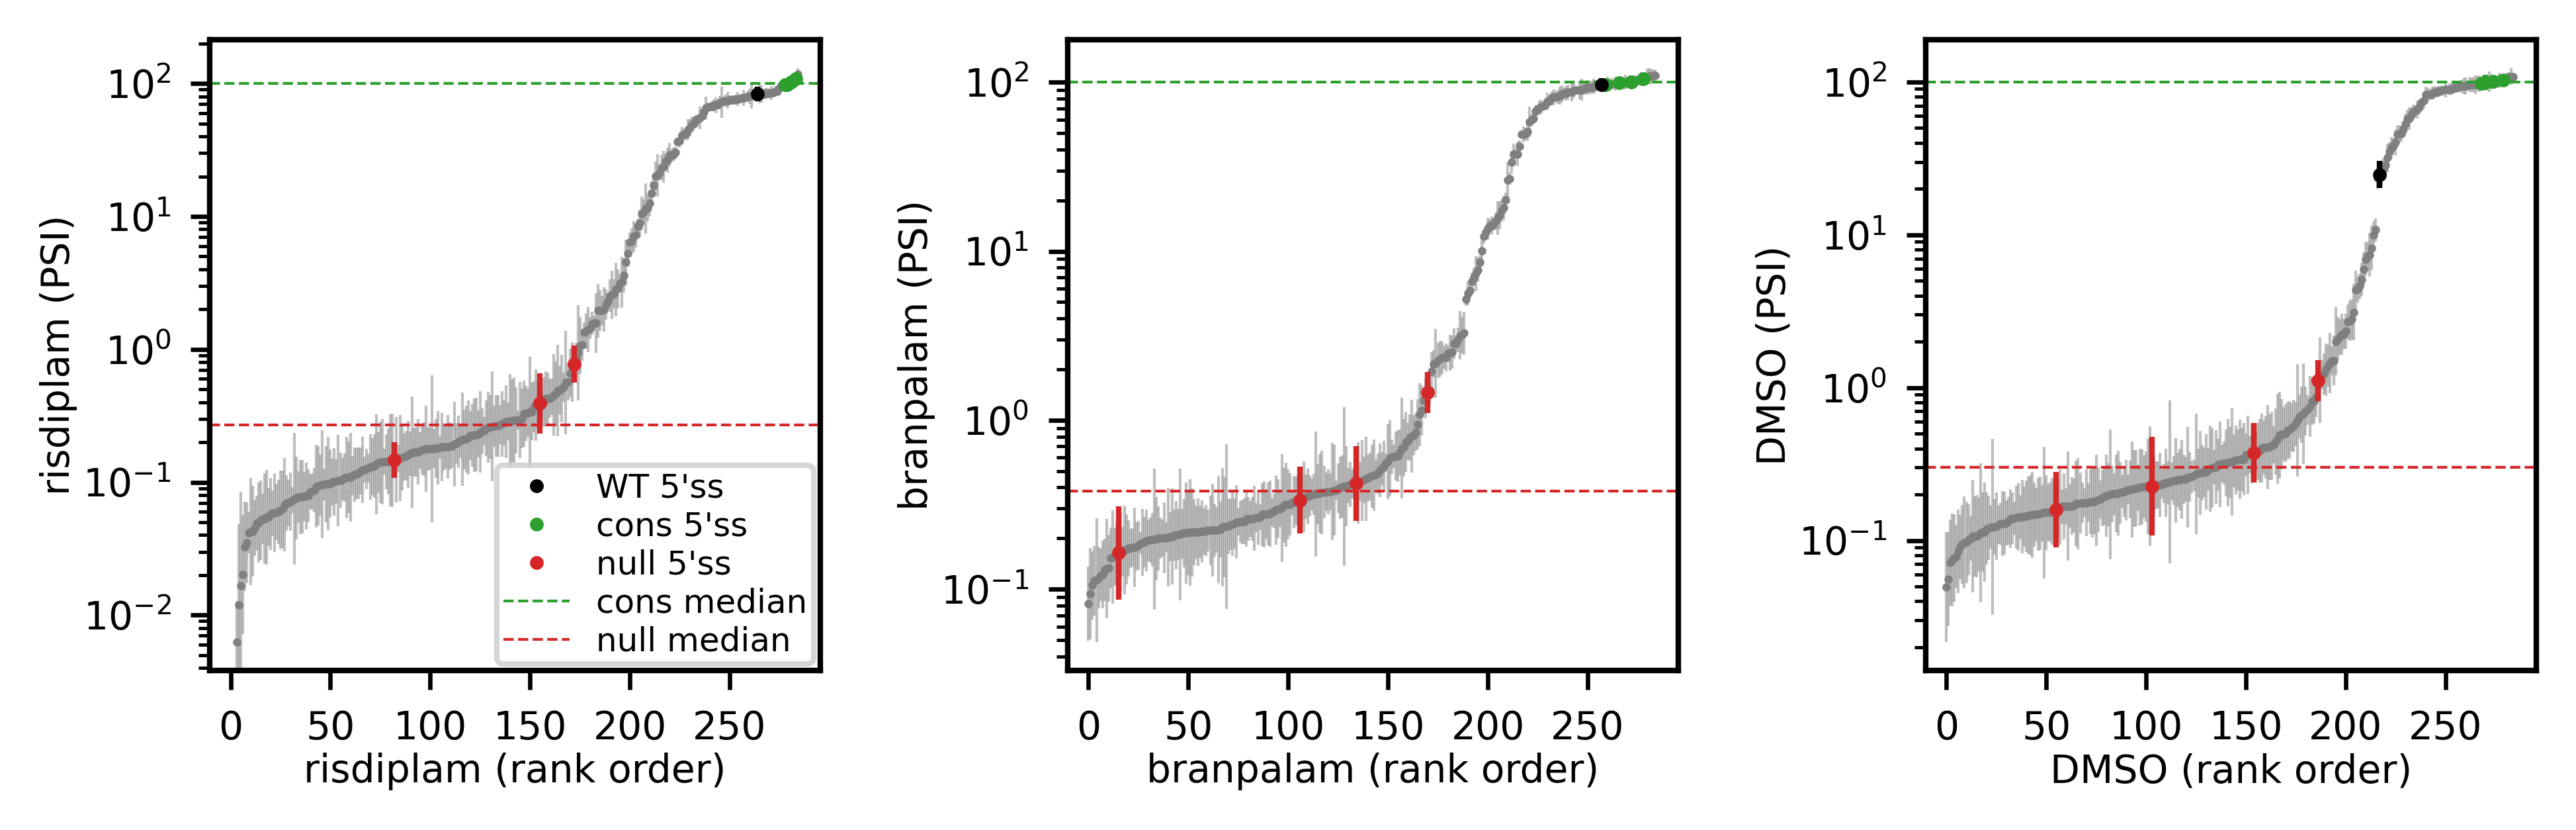

In [7]:
y_cols = ['smn2_dmso', 'smn2_rg', 'smn2_nvs']
dy_cols = [col+'_log_std' for col in y_cols]
num_5ss = len(smn2_df)

def draw(psi_col, ax, drug):
    y = smn2_df[psi_col]
    dy = smn2_df[psi_col+'_log_std']
    z = 1.96
    s = 1
    yerr = np.array([y - np.exp(np.log(y)-z*dy), np.exp(np.log(y)+z*dy) - y])
    ix = np.argsort(np.argsort(y))
    
    # Plot all data
    print(psi_col)
    ax.plot(ix, y, markersize=1, linewidth=0, marker='.', color='C7', rasterized=True)
    ax.errorbar(x=ix, y=y, yerr=yerr, linewidth=0, elinewidth=.5, alpha=.5, color='C7', rasterized=True)
        
    # Plot WT data
    ax.plot(ix[wt_ix], y[wt_ix], markersize=3, linewidth=0, marker='.', color='k', rasterized=True,
            label='WT 5\'ss', zorder=100)
    print(f'wt: y={y[wt_ix][0]:.0f}')
    ax.errorbar(x=ix[wt_ix], y=y[wt_ix], yerr=yerr[:,wt_ix], 
                linewidth=0, elinewidth=1, alpha=1, color='k', rasterized=True)
        
    # Plot cons data
    y_cons_med = y[cons_ix].median()
    print(f'cons median: y={y_cons_med:.0f}')
    ax.plot(ix[cons_ix], y[cons_ix], markersize=3, linewidth=0, marker='.', color='C2', rasterized=True,
            label='cons 5\'ss')
    ax.errorbar(x=ix[cons_ix], y=y[cons_ix], yerr=yerr[:,cons_ix], 
                linewidth=0, elinewidth=1, alpha=1, color='C2', rasterized=True)
    
    # Plot null data
    y_null_med = y[null_ix].median()
    print(f'null median: y={y_null_med:.2f}')
    ax.plot(ix[null_ix], y[null_ix], markersize=3, linewidth=0, marker='.', color='C3', rasterized=True,
            label='null 5\'ss')
    ax.errorbar(x=ix[null_ix], y=y[null_ix], yerr=yerr[:,null_ix], 
                linewidth=0, elinewidth=1, alpha=1, color='C3', rasterized=True)
    
    # Plot cons and null median lines
    ax.axhline(y_cons_med, alpha=1, linewidth=0.5, linestyle='--', color='C2', label='cons median')
    ax.axhline(y_null_med, alpha=1, linewidth=0.5, linestyle='--', color='C3', label='null median')
    
    # Style plot
    ax.set_yscale('log')
    ax.set_xlim([-10.5, num_5ss+10.5])
    ax.set_xticks([0, 50, 100, 150, 200, 250])
    #ax.axhline(100, linestyle=':', linewidth=.5, color='k', zorder=-100)
    #ax.axhline(100, linestyle='--', color='k', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.set_xlabel(f'{drug} (rank order)')
    ax.set_ylabel(f'{drug} (PSI)')
    
fig, axs = plt.subplots(1,3,figsize=[6.5, 2.1], sharey=False)

draw(ax=axs[0],
     drug='risdiplam',
     psi_col='smn2_rg')
axs[0].legend(fontsize=6, loc='lower right')

draw(ax=axs[1],
     drug='branpalam',
     psi_col='smn2_nvs')

draw(ax=axs[2],
     drug='DMSO',
     psi_col='smn2_dmso')

fig.tight_layout(w_pad=2)
fig.savefig('figS1ABC.pdf')


In [8]:
# Returns coordinates of positive and negative set polygons
def get_cut_polygons(pos_fold, 
                     neg_fold,
                     lo_psi, 
                     hi_psi,
                     bg_x_psi,
                     bg_y_psi,
                     lims):
    
    # Create curved part for positive selection
    c_grid = np.logspace(-4, 4, 1000)
    
    r_x = c_grid + bg_x_psi/100
    r_pos_y = pos_fold*c_grid + bg_y_psi/100
    r_neg_y = neg_fold*c_grid + bg_y_psi/100
    r_inv_y = (1/neg_fold)*c_grid + bg_y_psi/100
    
    psi_x = 100*r_x/(1+r_x)
    psi_pos_y = 100*r_pos_y/(1+r_pos_y)
    psi_neg_y = 100*r_neg_y/(1+r_neg_y)
    psi_inv_y = 100*r_inv_y/(1+r_inv_y)
    
    ix = (psi_pos_y > lo_psi) & (psi_x < hi_psi)
    pos_curve_xy = zip(psi_x[ix], psi_pos_y[ix])
    
    ix = (psi_neg_y > lo_psi) & (psi_x < hi_psi)
    neg_curve_xy = zip(psi_x[ix], psi_neg_y[ix])
    
    ix = (psi_x > lo_psi) & (psi_inv_y < hi_psi)
    inv_curve_xy = zip(psi_x[ix], psi_inv_y[ix])

    xmin = lims[0]
    xmax = lims[1]
    ymin = lims[0]
    ymax = lims[1]
    
    pos_xy = [(xmin, lo_psi)] + \
            list(pos_curve_xy) + [
            (hi_psi, ymax),
            (xmin, ymax),
            (xmin, lo_psi)]
    
    neg_xy = [(lo_psi, lo_psi)] + \
             list(neg_curve_xy) + \
             [(hi_psi, hi_psi)] +\
             list(inv_curve_xy)[::-1] +\
             [(lo_psi, lo_psi)]
    
    return pos_xy, neg_xy

# Returns array of bools stating whether polygon defined by points polygon_xy contains the points in points_xy
def does_polygon_contain(polygon_xy, points_xy):
    from shapely.geometry import Point, Polygon
    poly = Polygon(polygon_xy)
    points = [Point([x,y]) for x,y in points_xy]
    return np.array([poly.contains(point) for point in points])

In [9]:
# Define function to plot results
s = 20
bulkalpha=.5
si_figsize = [3.25,3.25]
figsize = [2,2]
N = len(seqs)
lims = [3E-2, 3E2]

# Shared ax style
def style_ax(ax, xlabel=None, ylabel=None):
    ticks = [1E-1, 1E0, 1E1, 1E2]
    lim = [3E-2, 3E2]
    
    ax.axhline(100, linestyle='--', color='k', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.axvline(100, linestyle='--', color='k', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.plot(lim, lim, 'k:', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')
    ax.minorticks_on()
    ax.legend(loc='lower right', framealpha=1, fontsize=6)

In [10]:
# Set psi data
psi_dmso = smn2_df['smn2_dmso']
psi_bran = smn2_df['smn2_nvs']
psi_ris = smn2_df['smn2_rg'] 

# Compute median null PSI for 3 treatments
psi_dmso_null = psi_dmso[null_ix].median()
psi_bran_null = psi_bran[null_ix].median()
psi_ris_null = psi_ris[null_ix].median()

# Define positive and negative regions for risdiplam treatment
ris_pos_xy, ris_neg_xy = get_cut_polygons(
                                bg_x_psi=psi_dmso_null,
                                bg_y_psi=psi_ris_null,
                                neg_fold=3,
                                pos_fold=4,
                                lo_psi=.67,
                                hi_psi=67,
                                lims=lims)

# Define positive and negative regions for branaplam treatment
bran_pos_xy, bran_neg_xy = get_cut_polygons(
                                bg_x_psi=psi_dmso_null,
                                bg_y_psi=psi_bran_null,
                                neg_fold=3,
                                pos_fold=6,
                                lo_psi=1.2,
                                hi_psi=40,
                                lims=lims)

# Define positive and negative regions for hyper motif
hyper_pos_xy, hyper_neg_xy = get_cut_polygons(
                                bg_x_psi=psi_ris_null,
                                bg_y_psi=psi_bran_null,
                                neg_fold=3,
                                pos_fold=6,
                                lo_psi=1.2,
                                hi_psi=40,
                                lims=lims)

/Users/jkinney/miniforge3_arm64/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jkinney/miniforge3_arm64/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


wt: y=83
wt: y=97
wt: y=97
Figure saved to figS1DEF.pdf


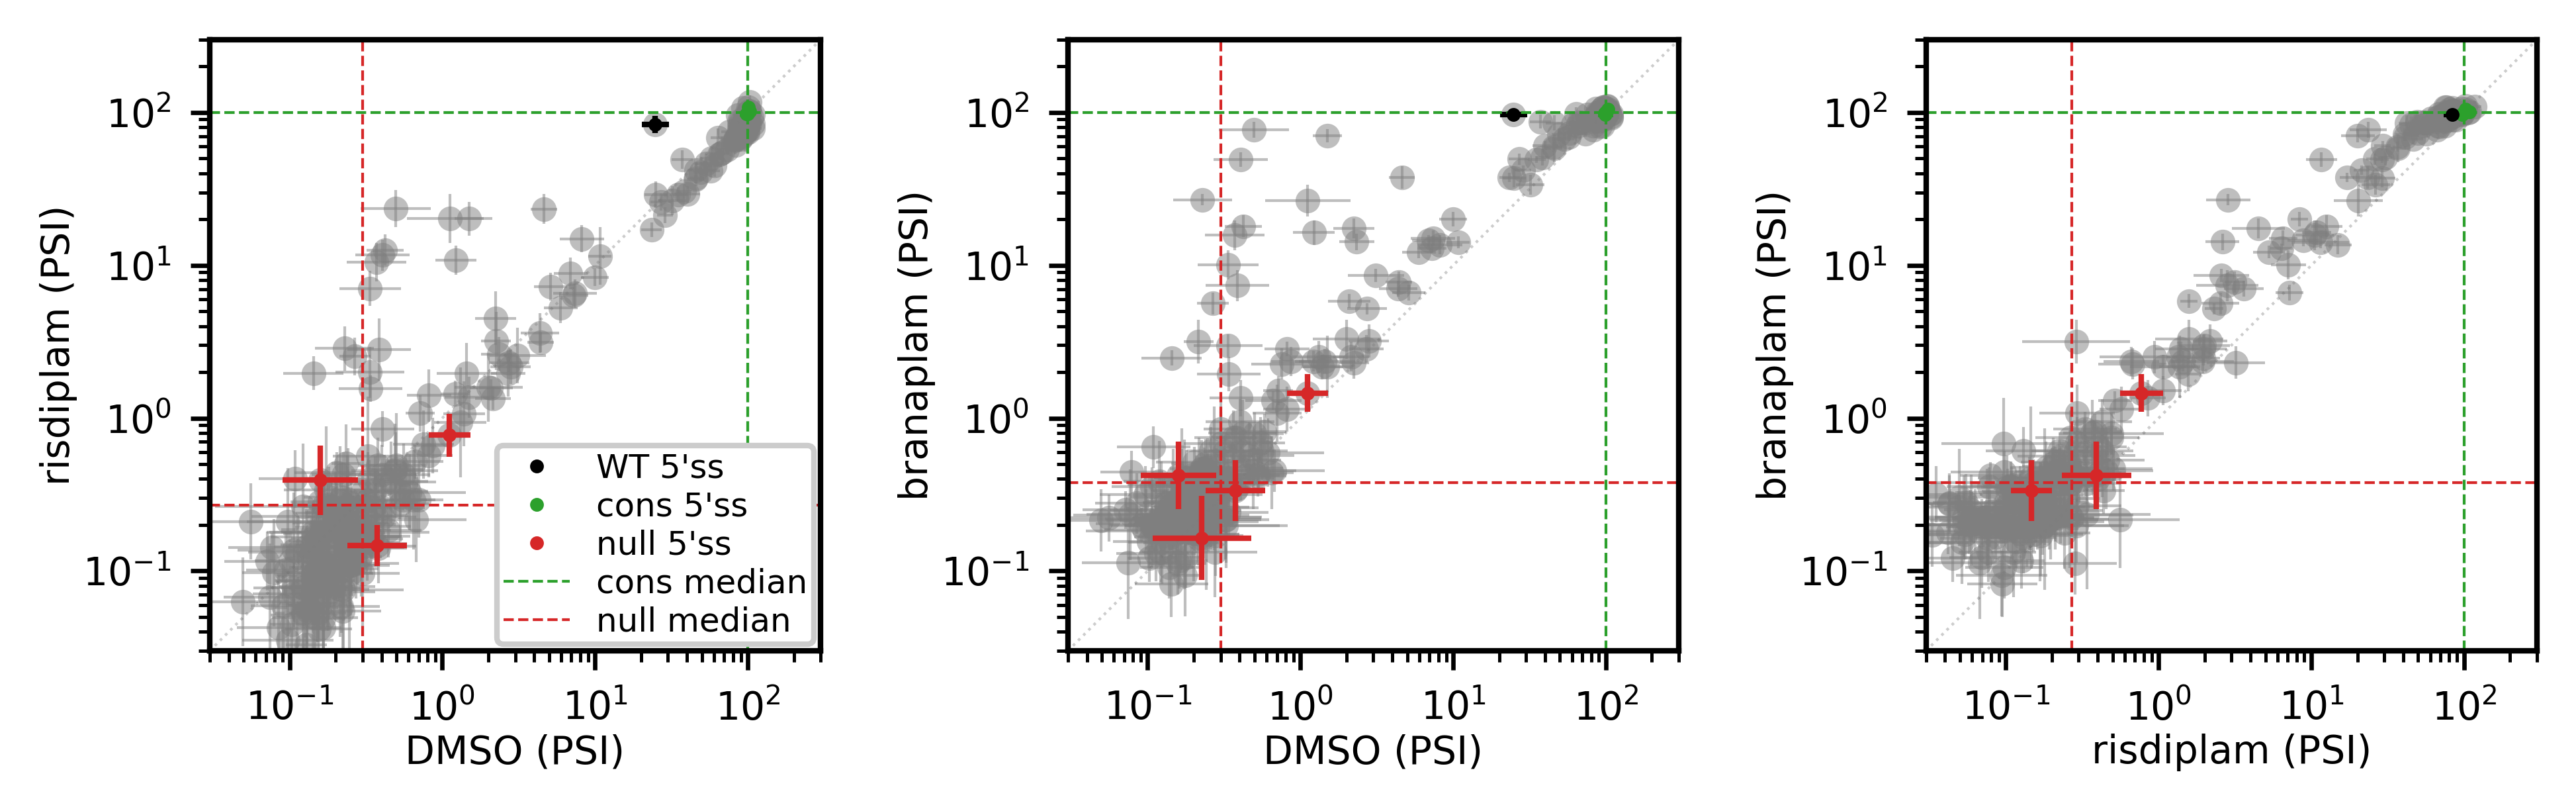

In [11]:
# Plot raw risdiplam values
z = 1.96

# Make figure
fig, axs = plt.subplots(1,3,figsize=[6.5,2.1])

xcols_xlabels_list = [('smn2_dmso', 'DMSO (PSI)'),
                      ('smn2_dmso', 'DMSO (PSI)'),
                      ('smn2_rg', 'risdiplam (PSI)')]

ycols_ylabels_list = [('smn2_rg', 'risdiplam (PSI)'),
                      ('smn2_nvs', 'branaplam (PSI)'),
                      ('smn2_nvs', 'branaplam (PSI)')]

# Iterate over risdiplam and branaplam
for i, ((xcol, xlabel), (ycol, ylabel)) in enumerate(zip(xcols_xlabels_list, ycols_ylabels_list)):
    
    # Set ax
    ax = axs[i]
    
    # Set risdiplam/DMSO specific data
    x=smn2_df[xcol] 
    dx = smn2_df[xcol+'_log_std']
    xerr = np.array([x - np.exp(np.log(x)-z*dx), np.exp(np.log(x)+z*dx) - x])
    
    # Set y coordinate
    y=smn2_df[ycol]
    dy = smn2_df[ycol+'_log_std']
    yerr = np.array([y - np.exp(np.log(y)-z*dy), np.exp(np.log(y)+z*dy) - y])
  
    # Plot all data
    ax.scatter(x, y, alpha=bulkalpha, s=s, linewidth=0, color='C7')
    ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, 
                linewidth=0, elinewidth=.5, alpha=.5, color='C7', rasterized=True,
                zorder=-100)

    # Plot WT data
    ax.plot(x[wt_ix], y[wt_ix], markersize=3, linewidth=0, marker='.', color='k', rasterized=True,
            label='WT 5\'ss', zorder=100)
    print(f'wt: y={y[wt_ix][0]:.0f}')
    ax.errorbar(x=x[wt_ix], y=y[wt_ix], xerr=xerr[:,wt_ix], yerr=yerr[:,wt_ix], 
                linewidth=0, elinewidth=1, alpha=1, color='k', rasterized=True)
        
    # Plot cons data
    x_cons_med = x[cons_ix].median()
    y_cons_med = y[cons_ix].median()
    ax.plot(x[cons_ix], y[cons_ix], markersize=3, linewidth=0, marker='.', color='C2', rasterized=True,
            label='cons 5\'ss')
    ax.errorbar(x=x[cons_ix], y=y[cons_ix], xerr=xerr[:,cons_ix], yerr=yerr[:,cons_ix], 
                linewidth=0, elinewidth=1, alpha=1, color='C2', rasterized=True)
    
    # Plot null data
    x_null_med = x[null_ix].median()
    y_null_med = y[null_ix].median()
    ax.plot(x[null_ix], y[null_ix], markersize=3, linewidth=0, marker='.', color='C3', rasterized=True,
            label='null 5\'ss')
    ax.errorbar(x=x[null_ix], y=y[null_ix], xerr=xerr[:,null_ix], yerr=yerr[:,null_ix], 
                linewidth=0, elinewidth=1, alpha=1, color='C3', rasterized=True)
    
    # Plot cons and null median lines
    ax.axvline(x_cons_med, alpha=1, linewidth=0.5, linestyle='--', color='C2', label='cons median')
    ax.axhline(y_cons_med, alpha=1, linewidth=0.5, linestyle='--', color='C2')
    ax.axvline(x_null_med, alpha=1, linewidth=0.5, linestyle='--', color='C3', label='null median')
    ax.axhline(y_null_med, alpha=1, linewidth=0.5, linestyle='--', color='C3')

    # Style ax
    style_ax(ax, xlabel=xlabel, ylabel=ylabel)

    utils.add_click_labels(x, y, seqs, ax)
    if i==0:
        ax.legend(loc='lower right', framealpha=1, fontsize=6)
    else:
        ax.get_legend().remove()

# Save figure
plt.tight_layout(w_pad=2)
fig_name = 'figS1DEF.pdf'
fig.savefig(fig_name)
print(f'Figure saved to {fig_name}')

In [12]:
# def get_sufficient_and_necessary_motifs(seqs, in_ix, ex_ix, num_trials=2, verbose=False):

#     # First compute most restrictive motif that matches all 'in' sequences
#     # If this motif also excludes all excluded sequences, it will be the 
#     # "sufficient motif"
#     motif = 'xxxx/GUxxxx'
#     poss = [-4,-3,-2,-1,3,4,5,6] 
#     motif_list = list(motif)
#     bases = list('ACGU')
#     seqs = np.array(seqs)
#     if in_ix is not None:
#         in_seqs = seqs[in_ix]
#     for pos in poss:
#         i = pos+4
#         bs = list(set([seq[i] for seq in in_seqs]))
#         bs.sort()
#         bs = tuple(bs)
#         iupac = utils._bs_to_iupac_dict[bs]
#         motif_list[i] = iupac
#     all_in_motif = ''.join(motif_list)
    
#     # If this motif does NOT match any excluded sequences, it is a sufficient motif
#     ix = utils.motif_to_ix(motif=all_in_motif,
#                            seqs=seqs)
#     if sum(ix & ex_ix)>0:
#         print('Could not find sufficient motif. Returning all_in_motif instead')
#         return all_in_motif, None
    
#     # Define sufficient motif
#     sufficient_motif = all_in_motif
                
#     # Create dataframe to hold maximal motifs from multiple trials
#     motif_df = pd.DataFrame(index=range(num_trials), columns=['motif'])
    
#     # Perform trials
#     for trial_num in range(num_trials):

#         # Initialize using from sufficient motif
#         motif = sufficient_motif
#         motif_altered = True
#         num_loops = 0
        
#         # While motif keeps being altered, iterate over all pos and b
#         while motif_altered:
#             motif_altered = False
#             num_loops += 1
#             if verbose:
#                 print(f'In loop {num_loops}')

#             # Iterate over randomized positions pos
#             np.random.shuffle(poss)
#             for pos in poss:
#                 i = pos+4

#                 # Iterate over randomized bases b
#                 np.random.shuffle(bases)
#                 for b in bases:

#                     # If b is not already permitted by motif
#                     iupac = motif[i]
#                     allowed_bs = utils._iupac_to_bs_dict[iupac]
#                     if b not in allowed_bs:

#                         # Add b to allowed bs
#                         new_bs = list(allowed_bs)
#                         new_bs.append(b)
#                         new_bs.sort()
#                         new_bs = tuple(new_bs)

#                         # Get iupac symbol for bs
#                         new_iupac = utils._bs_to_iupac_dict[new_bs]

#                         # Create new motif
#                         new_motif_list = list(motif)
#                         new_motif_list[i] = new_iupac
#                         new_motif = ''.join(new_motif_list)

#                         # Determine new sequences hit
#                         new_re = utils.iupac_to_regex(new_motif)
#                         new_ix = np.array([bool(re.match(new_re, seq)) for seq in seqs])

#                         # Compute number of non-activted seqs
#                         nact_seqs_hit = sum(new_ix & ex_ix)
#                         act_seqs_hit = sum(new_ix & in_ix)
#                         N_act = sum(in_ix)

#                         # If new motif does not hit non-activated seqs AND hits all activated sequences, save
#                         if (nact_seqs_hit == 0) and (act_seqs_hit == N_act):
#                             motif = new_motif
#                             motif_altered = True
#                             if verbose:
#                                 print(f'Motif altered to add {b} at {pos:+d}')
                                
#         if verbose:
#             print(f'Final motif found in {num_loops} loops: {motif}')
        
#         # Save motif
#         motif_df.loc[trial_num,'motif'] = motif

#     # Collapse motif_df so motifs are unique, with counts listed
#     motif_df['trials'] = 1
#     if verbose:
#         print(motif_df)
#     motif_df = motif_df.groupby('motif').sum().reset_index()
    
#     # Compute mass and num positives for each identified motif
#     motif_df['mass'] = 0
#     for i in range(len(motif_df)):
#         motif = motif_df.loc[i,'motif']
#         motif_df.loc[i,'mass'] = utils.motif_to_mass(motif)
        
#     # Sort by mass, then by ct
#     motif_df.sort_values(by=['mass', 'trials'], 
#                          ascending=False, 
#                          inplace=True)
#     motif_df.reset_index(inplace=True, drop=True)
    
#     # Define necessary motif
#     necessary_motif = motif_df.loc[0,'motif']
            
#     # Return sufficient and necessary motifs
#     return sufficient_motif, necessary_motif

motif        trials
ANGA/GUHDNN  1         100
dtype: int64
risdiplam sufficient motif: ANGA/GUADGN
risdiplam necessary motif: ANGA/GUHDNN


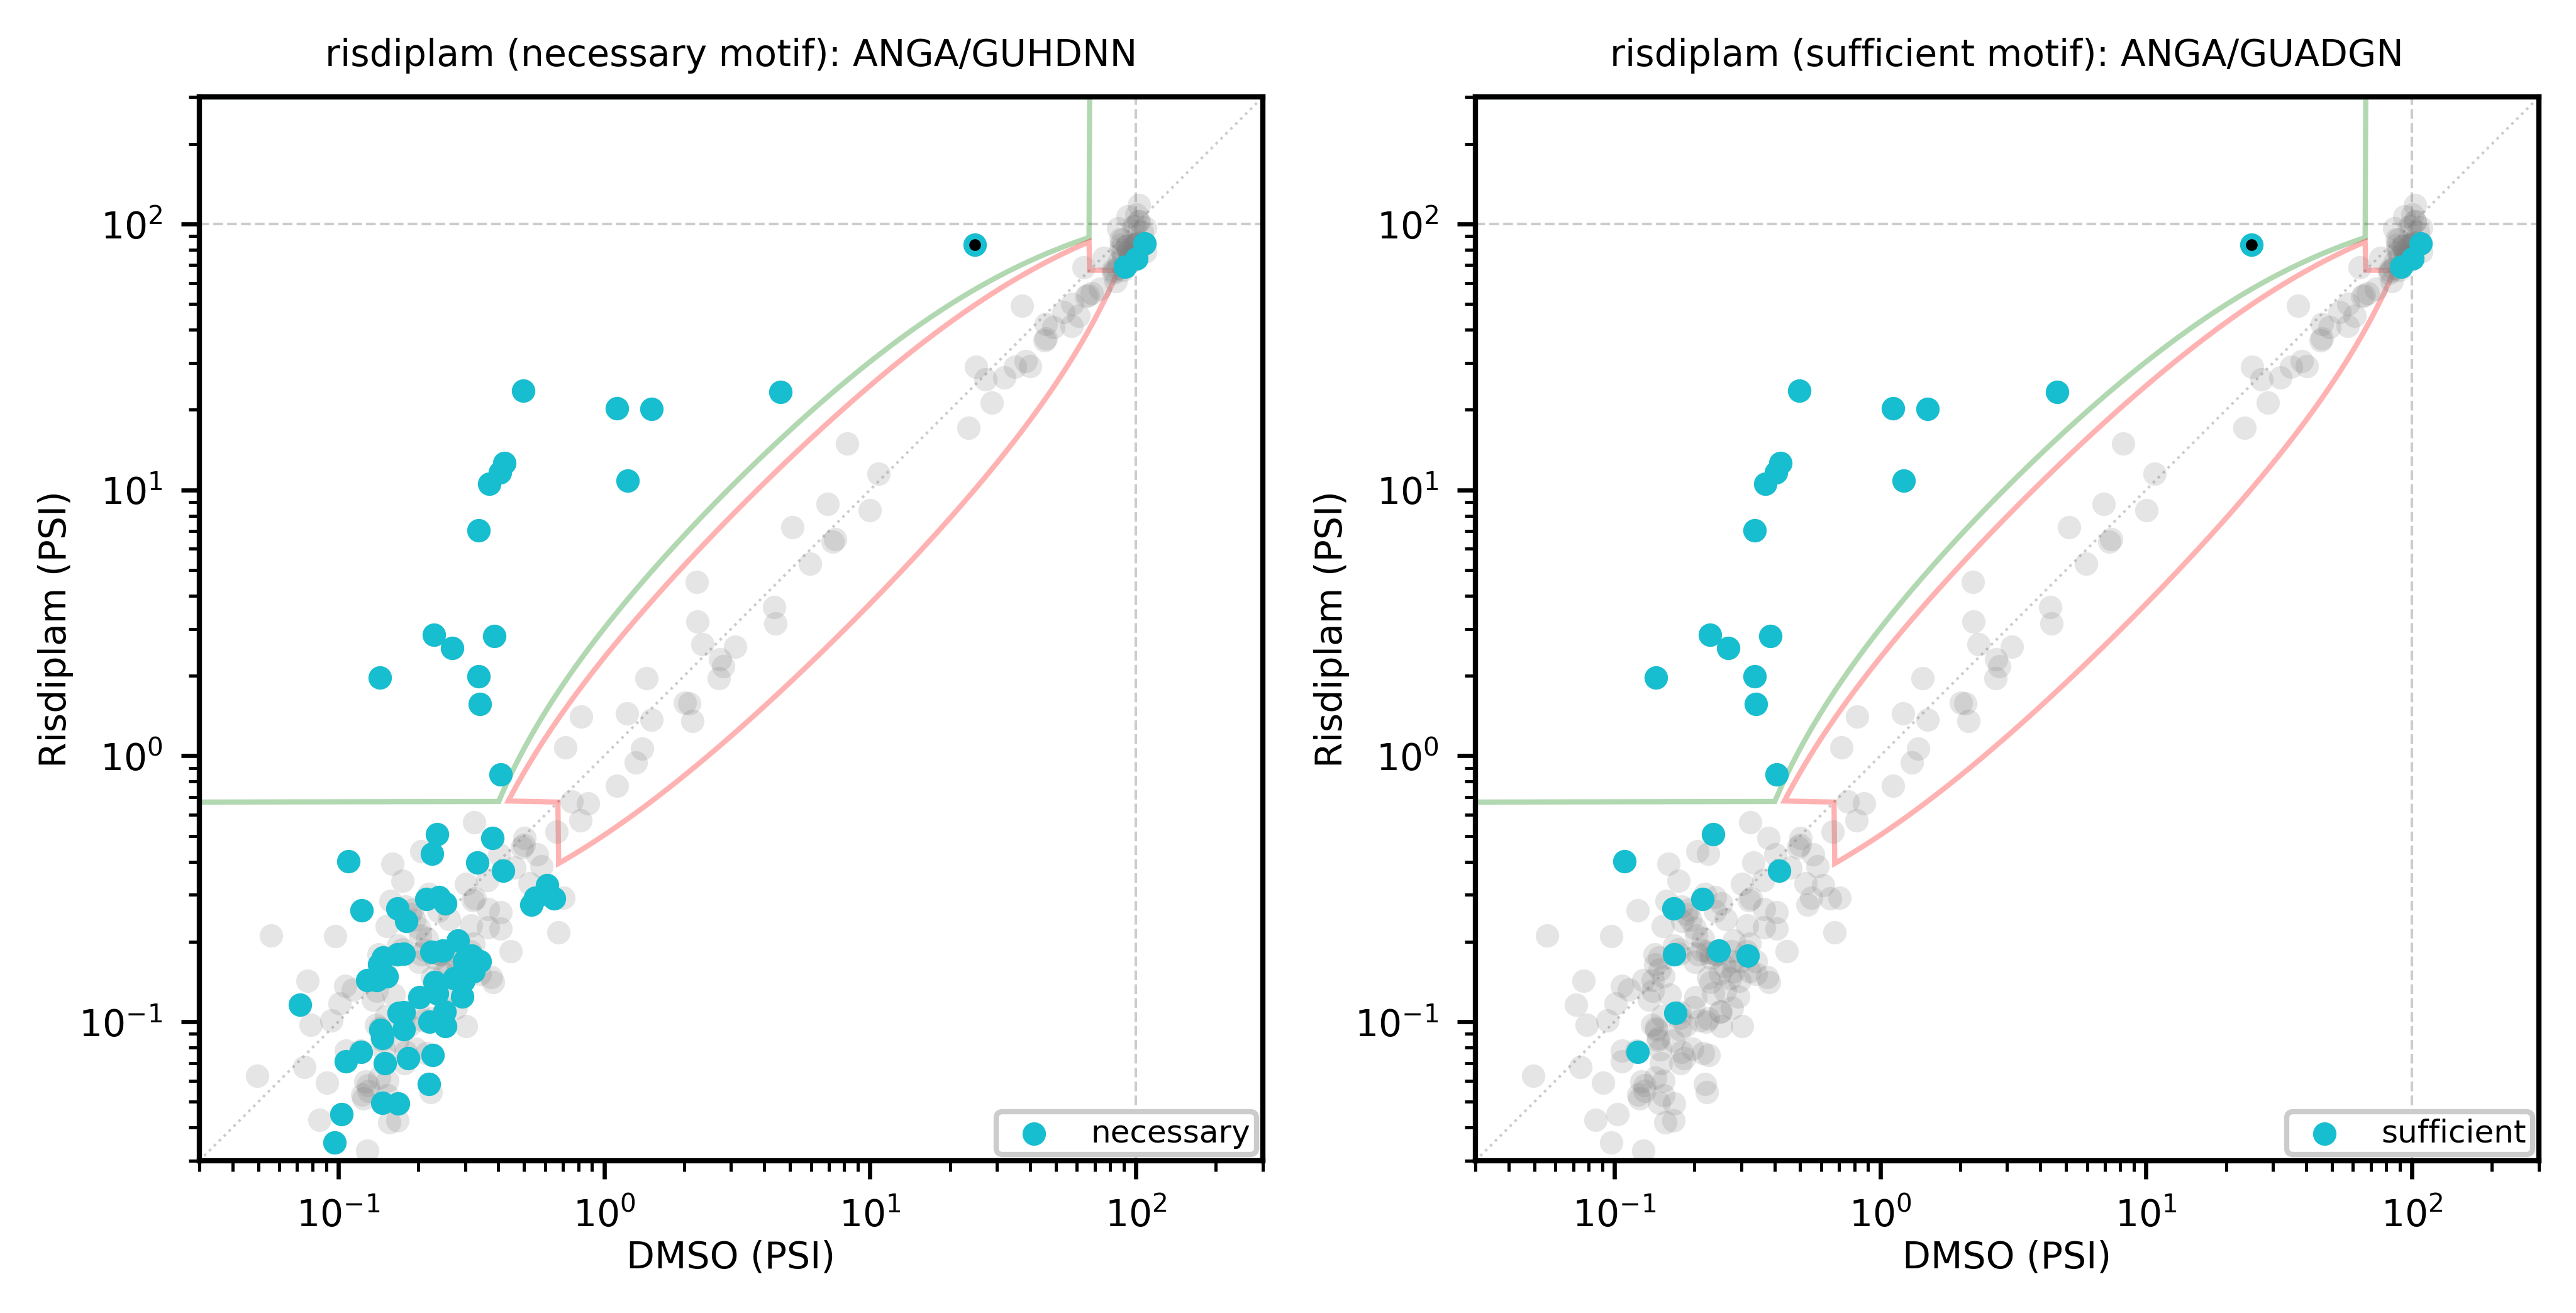

In [13]:
# Compute sufficient and necessary risdiplam motifs

# Set runtime params
motif_prefix = 'risdiplam'
xlabel = 'DMSO (PSI)'
ylabel = 'Risdiplam (PSI)'
x=smn2_df['smn2_dmso'] 
y=smn2_df['smn2_rg']
pos_xy = ris_pos_xy
neg_xy = ris_neg_xy

# Define set of activated and non-activated sites
act_ix = does_polygon_contain(pos_xy, zip(x,y)) 
nact_ix = does_polygon_contain(neg_xy, zip(x,y)) 
und_ix = (~act_ix) & (~nact_ix)

###
### Compute min risdiplam motif (aka necessary motif) and risdiplam max motif (aka necessary motif)
###

# Compute maximal motif and associated stats
sufficient_motif, necessary_motif = \
    utils.get_sufficient_and_necessary_motifs(seqs, 
                                        in_ix=act_ix,
                                        ex_ix=nact_ix, 
                                        num_trials=100,
                                        verbose=True)
print(f'{motif_prefix} sufficient motif: {sufficient_motif}')
print(f'{motif_prefix} necessary motif: {necessary_motif}')
sufficient_ix = utils.motif_to_ix(sufficient_motif, seqs)
necessary_ix = utils.motif_to_ix(necessary_motif, seqs)

def draw(ax, ix, label, motif):
    patch_kwargs = dict(facecolor = 'none', linestyle='-', linewidth=1, alpha=.3)
    ax.add_patch(Polygon(pos_xy, edgecolor='g', **patch_kwargs))
    ax.add_patch(Polygon(neg_xy, edgecolor='r', **patch_kwargs))
    ax.scatter(x, y, alpha=.2, s=s, linewidth=0, color='C7')
    ax.scatter(x[ix], y[ix], alpha=1, s=s, linewidth=0, facecolor='C9', label=label)
    ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k')
    style_ax(ax, xlabel=xlabel, ylabel=ylabel)
    utils.add_click_labels(x, y, seqs, ax)
    ax.set_title(f'{motif_prefix} ({label} motif): {motif}')
    
# View results
fig, axs = plt.subplots(1,2,figsize=[8,4])
draw(ax=axs[0], ix=necessary_ix, label='necessary', motif=necessary_motif)
draw(ax=axs[1], ix=sufficient_ix, label='sufficient', motif=sufficient_motif)

# Save motifs
ris_sufficient_motif = sufficient_motif
ris_necessary_motif = necessary_motif

In [14]:
# Function to draw probability logos
def draw_logo(motif, ax, title, highlight=(), min_motif=None):
    L = 10
    xticklabels = [f'{x:+d}' for x in range(-4,7) if not x==0]
    motif_df = lm.sequence_to_matrix(motif.replace('/','').replace('U','T'), 
                                     is_iupac=True)
    motif_df.columns = list('ACGU')
    logo = lm.Logo(motif_df, 
                   stack_order='fixed',
                   ax=ax, 
                   show_spines=False, 
                   baseline_width=0, 
                   font_name='Arial Rounded MT Bold', 
                   width=.9,
                   fade_probabilities=True)
    ax.set_yticks([])
    ax.set_xticks(range(L))
    ax.set_xticklabels(xticklabels)
    ax.set_title(title, fontsize=7)
    ax.tick_params(length=0, labelsize=5, pad=1)
    ax.axvline(3.5, linestyle=':', linewidth=1, color='k')
    #ax.set_ylim([-.05,1.05])
    
    for pos,base in [(+1,'G'),(+2,'U')]:
        pos = pos+4 if pos < 0 else pos+3
        logo.style_single_glyph(c=base, p=pos, color='k')
        
    # Compute which bases are uncertain
    if min_motif:    
        min_motif_df = lm.sequence_to_matrix(min_motif.replace('/','').replace('U','T'), 
                                             is_iupac=True)
        min_motif_df.columns = list('ACGU')
        for pos in range(L-1):
            for base in list('ACGU'):
                if (motif_df.loc[pos,base]>0) and (min_motif_df.loc[pos,base]==0):
                    logo.style_single_glyph(c=base, p=pos, color='gray', alpha=.5)
    
    for pos, base in highlight:
        pos = pos+4 if pos < 0 else pos+3
        logo.style_single_glyph(c=base, p=pos, color='gray', alpha=.5) 

Could not find sufficient motif. Returning all_in_motif instead
branaplam minimal pos motif: RNGA/GURNGN
Could not find sufficient motif. Returning all_in_motif instead
branaplam minimal pos motif: RNGA/GURNGN
Could not find sufficient motif. Returning all_in_motif instead
branaplam minimal pos motif: RNGA/GUANGN


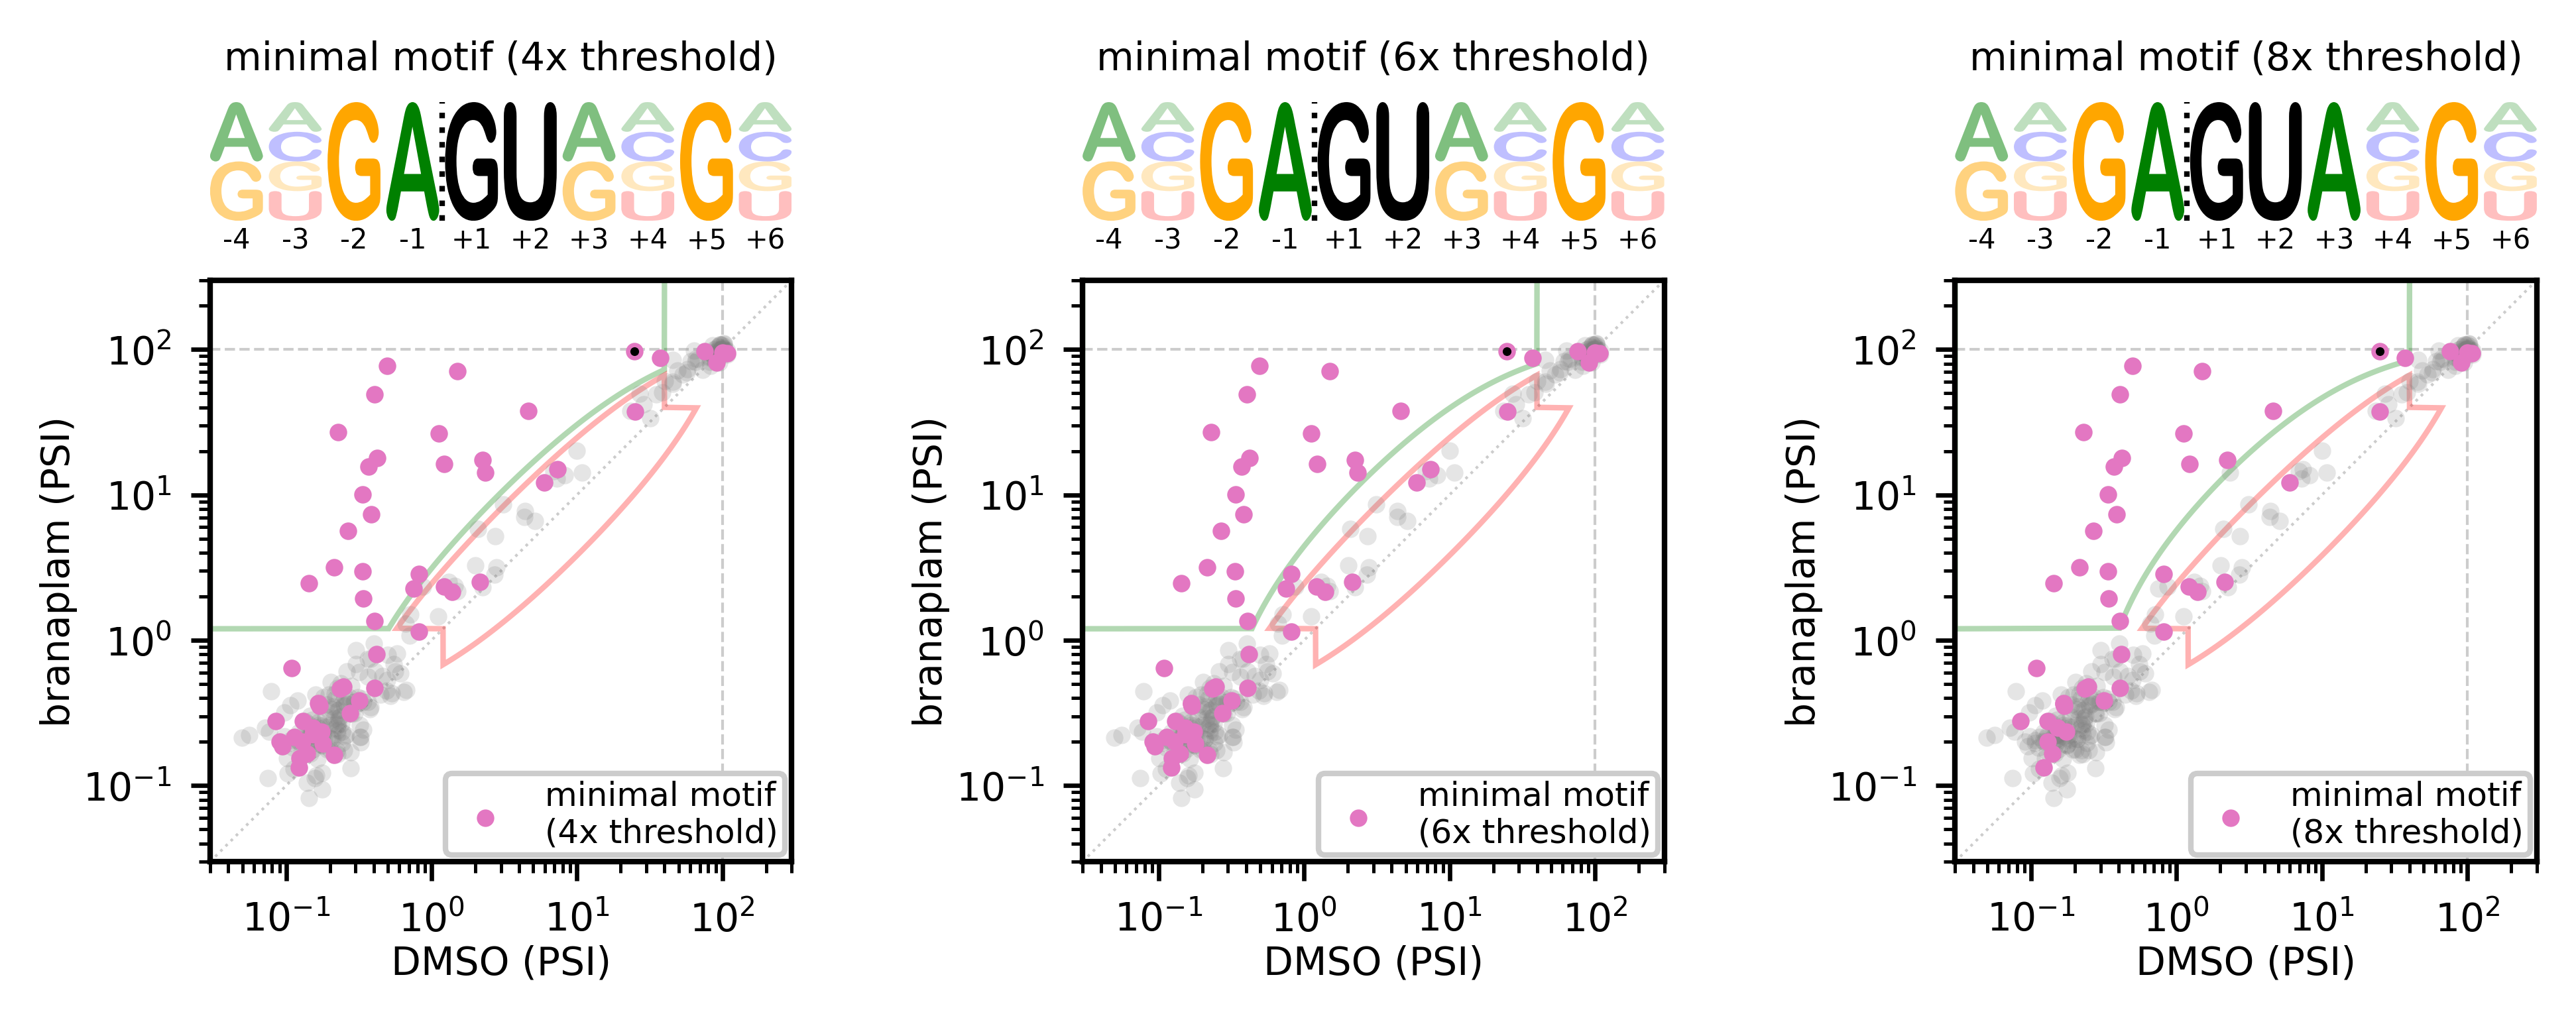

In [15]:
# Compute sufficient and necessary risdiplam motifs

# Set runtime params
motif_prefix = 'branaplam'
xlabel = 'DMSO (PSI)'
ylabel = 'branaplam (PSI)'

x=smn2_df['smn2_dmso'] 
y=smn2_df['smn2_nvs']

# Define positive and negative regions for branaplam treatment
pos_folds = np.array([4, 6, 8])

fig= plt.figure(figsize=[6.5, 2.5])
gs = GridSpec(2, 3, height_ratios=[.2,1], hspace=.15, wspace=.5, left=.08, right=.98)
s=10
bulkalpha=.3

for i in range(3):
    pos_fold = pos_folds[i]
    neg_fold = 3
    pos_xy, neg_xy = get_cut_polygons(
                                bg_x_psi=psi_dmso_null,
                                bg_y_psi=psi_bran_null,
                                neg_fold=3, #neg_folds[i],
                                pos_fold=pos_fold,
                                lo_psi=1.2,
                                hi_psi=40,
                                lims=lims)

    # Define set of activated and non-activated sites
    act_ix = does_polygon_contain(pos_xy, zip(x,y)) 
    nact_ix = does_polygon_contain(neg_xy, zip(x,y)) 
    und_ix = (~act_ix) & (~nact_ix)

    def draw(ax, ix, label, motif):
        patch_kwargs = dict(facecolor = 'none', linestyle='-', linewidth=1, alpha=.3)
        ax.add_patch(Polygon(pos_xy, edgecolor='g', **patch_kwargs))
        ax.add_patch(Polygon(neg_xy, edgecolor='r', **patch_kwargs))
        ax.scatter(x, y, alpha=.2, s=s, linewidth=0, color='C7')
        ax.scatter(x[ix], y[ix], alpha=1, s=s, linewidth=0, facecolor='C6', label=label)
        ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k')
        style_ax(ax, xlabel=xlabel, ylabel=ylabel)
        utils.add_click_labels(x, y, seqs, ax)
        ax.set_title(f'{label} motif: {motif}')


    # Compute maximal motif and associated stats
    minimal_motif, __ = \
        utils.get_sufficient_and_necessary_motifs(seqs, 
                                                  in_ix=act_ix,
                                                  ex_ix=nact_ix, 
                                                  num_trials=100)
    print(f'{motif_prefix} minimal pos motif: {minimal_motif}')
    minimal_ix = utils.motif_to_ix(minimal_motif, seqs)

    # Draw logo
    draw_logo(motif=minimal_motif, 
              ax=fig.add_subplot(gs[0,i]),
              title=f'minimal motif ({pos_fold}x threshold)')

    # Draw scatter
    ax = fig.add_subplot(gs[1,i])
    draw(ax=ax, 
         ix=minimal_ix, 
         label=f'minimal motif\n({pos_fold}x threshold)', 
         motif=minimal_motif)
    ax.set_title('')
    
fig.savefig('figS3.pdf')

In [16]:
# # Compute sufficient and necessary risdiplam motifs

# # Set runtime params
# motif_prefix = 'branaplam'
# xlabel = 'DMSO (PSI)'
# ylabel = 'branaplam (PSI)'
# x=smn2_df['smn2_dmso'] 
# y=smn2_df['smn2_nvs']
# pos_xy = bran_pos_xy
# neg_xy = bran_neg_xy

# # Define set of activated and non-activated sites
# act_ix = does_polygon_contain(pos_xy, zip(x,y)) 
# nact_ix = does_polygon_contain(neg_xy, zip(x,y)) 
# und_ix = (~act_ix) & (~nact_ix)

# ###
# ### Compute bra min motif (doesn't work)
# ###

# # Compute maximal motif and associated stats
# minimal_motif, __ = \
#     utils.get_sufficient_and_necessary_motifs(seqs, 
#                                         in_ix=act_ix,
#                                         ex_ix=nact_ix, 
#                                         num_trials=100)
# print(f'{motif_prefix} minimal pos motif: {minimal_motif}')
# minimal_ix = utils.motif_to_ix(minimal_motif, seqs)

# def draw(ax, ix, label, motif):
#     patch_kwargs = dict(facecolor = 'none', linestyle='-', linewidth=1, alpha=.3)
#     ax.add_patch(Polygon(pos_xy, edgecolor='g', **patch_kwargs))
#     ax.add_patch(Polygon(neg_xy, edgecolor='r', **patch_kwargs))
#     ax.scatter(x, y, alpha=.2, s=s, linewidth=0, color='C7')
#     ax.scatter(x[ix], y[ix], alpha=1, s=s, linewidth=0, facecolor='C6', label=label)
#     ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k')
#     style_ax(ax, xlabel=xlabel, ylabel=ylabel)
#     utils.add_click_labels(x, y, seqs, ax)
#     ax.set_title(f'{label} motif: {motif}')

# # View results
# fig, ax = plt.subplots(1,1,figsize=[3.25,3.25])
# draw(ax=ax, ix=minimal_ix, label='bra min', motif=minimal_motif)
# fig.tight_layout()
# #fig.savefig('fig1_S5_ipynb.pdf')

In [17]:
# # Compute sufficient and necessary risdiplam motifs ONLY using bran vs. ris
# # Use ONLY ris data

# # Set runtime params
# motif_prefix = 'hyper'
# xlabel = 'Risdiplam (PSI)'
# ylabel = 'Branaplam (PSI)'
# x=smn2_df['smn2_rg'] 
# y=smn2_df['smn2_nvs']
# pos_xy = hyper_pos_xy
# neg_xy = hyper_neg_xy

# # Define set of activated and non-activated sites
# act_ix = does_polygon_contain(pos_xy, zip(x,y)) 
# nact_ix = does_polygon_contain(neg_xy, zip(x,y)) 
# und_ix = (~act_ix) & (~nact_ix)

# # Compute maximal motif and associated stats
# sufficient_motif, necessary_motif = \
#     get_sufficient_and_necessary_motifs(seqs, 
#                                         in_ix=act_ix,
#                                         ex_ix=nact_ix, 
#                                         num_trials=100)
# print(f'{motif_prefix} sufficient motif: {sufficient_motif}')
# print(f'{motif_prefix} necessary motif: {necessary_motif}')
# sufficient_ix = utils.motif_to_ix(sufficient_motif, seqs)
# necessary_ix = utils.motif_to_ix(necessary_motif, seqs)

# def draw(ax, ix, label, motif):
#     patch_kwargs = dict(linewidth=0, alpha=.1)
#     ax.add_patch(Polygon(pos_xy, facecolor='g', **patch_kwargs))
#     ax.add_patch(Polygon(neg_xy, facecolor='r', **patch_kwargs))
#     ax.scatter(x, y, alpha=.2, s=s, linewidth=0, color='C7',  label='all')
#     ax.scatter(x[ix], y[ix], alpha=1, s=s, linewidth=0, facecolor='C9', label=label)
#     ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', label='wt')
#     style_ax(ax, xlabel=xlabel, ylabel=ylabel)
#     utils.add_click_labels(x, y, seqs, ax)
#     ax.set_title(f'{motif_prefix} ({label} motif): {motif}')

# # View results
# fig, axs = plt.subplots(1,2,figsize=[8,4])
# draw(ax=axs[0], ix=necessary_ix, label='necessary', motif=necessary_motif)
# draw(ax=axs[1], ix=sufficient_ix, label='sufficient', motif=sufficient_motif)

motif        trials
NANN/GUNNNN  1         100
dtype: int64
hyper sufficient motif: RAGA/GURNGN
hyper necessary motif: NANN/GUNNNN


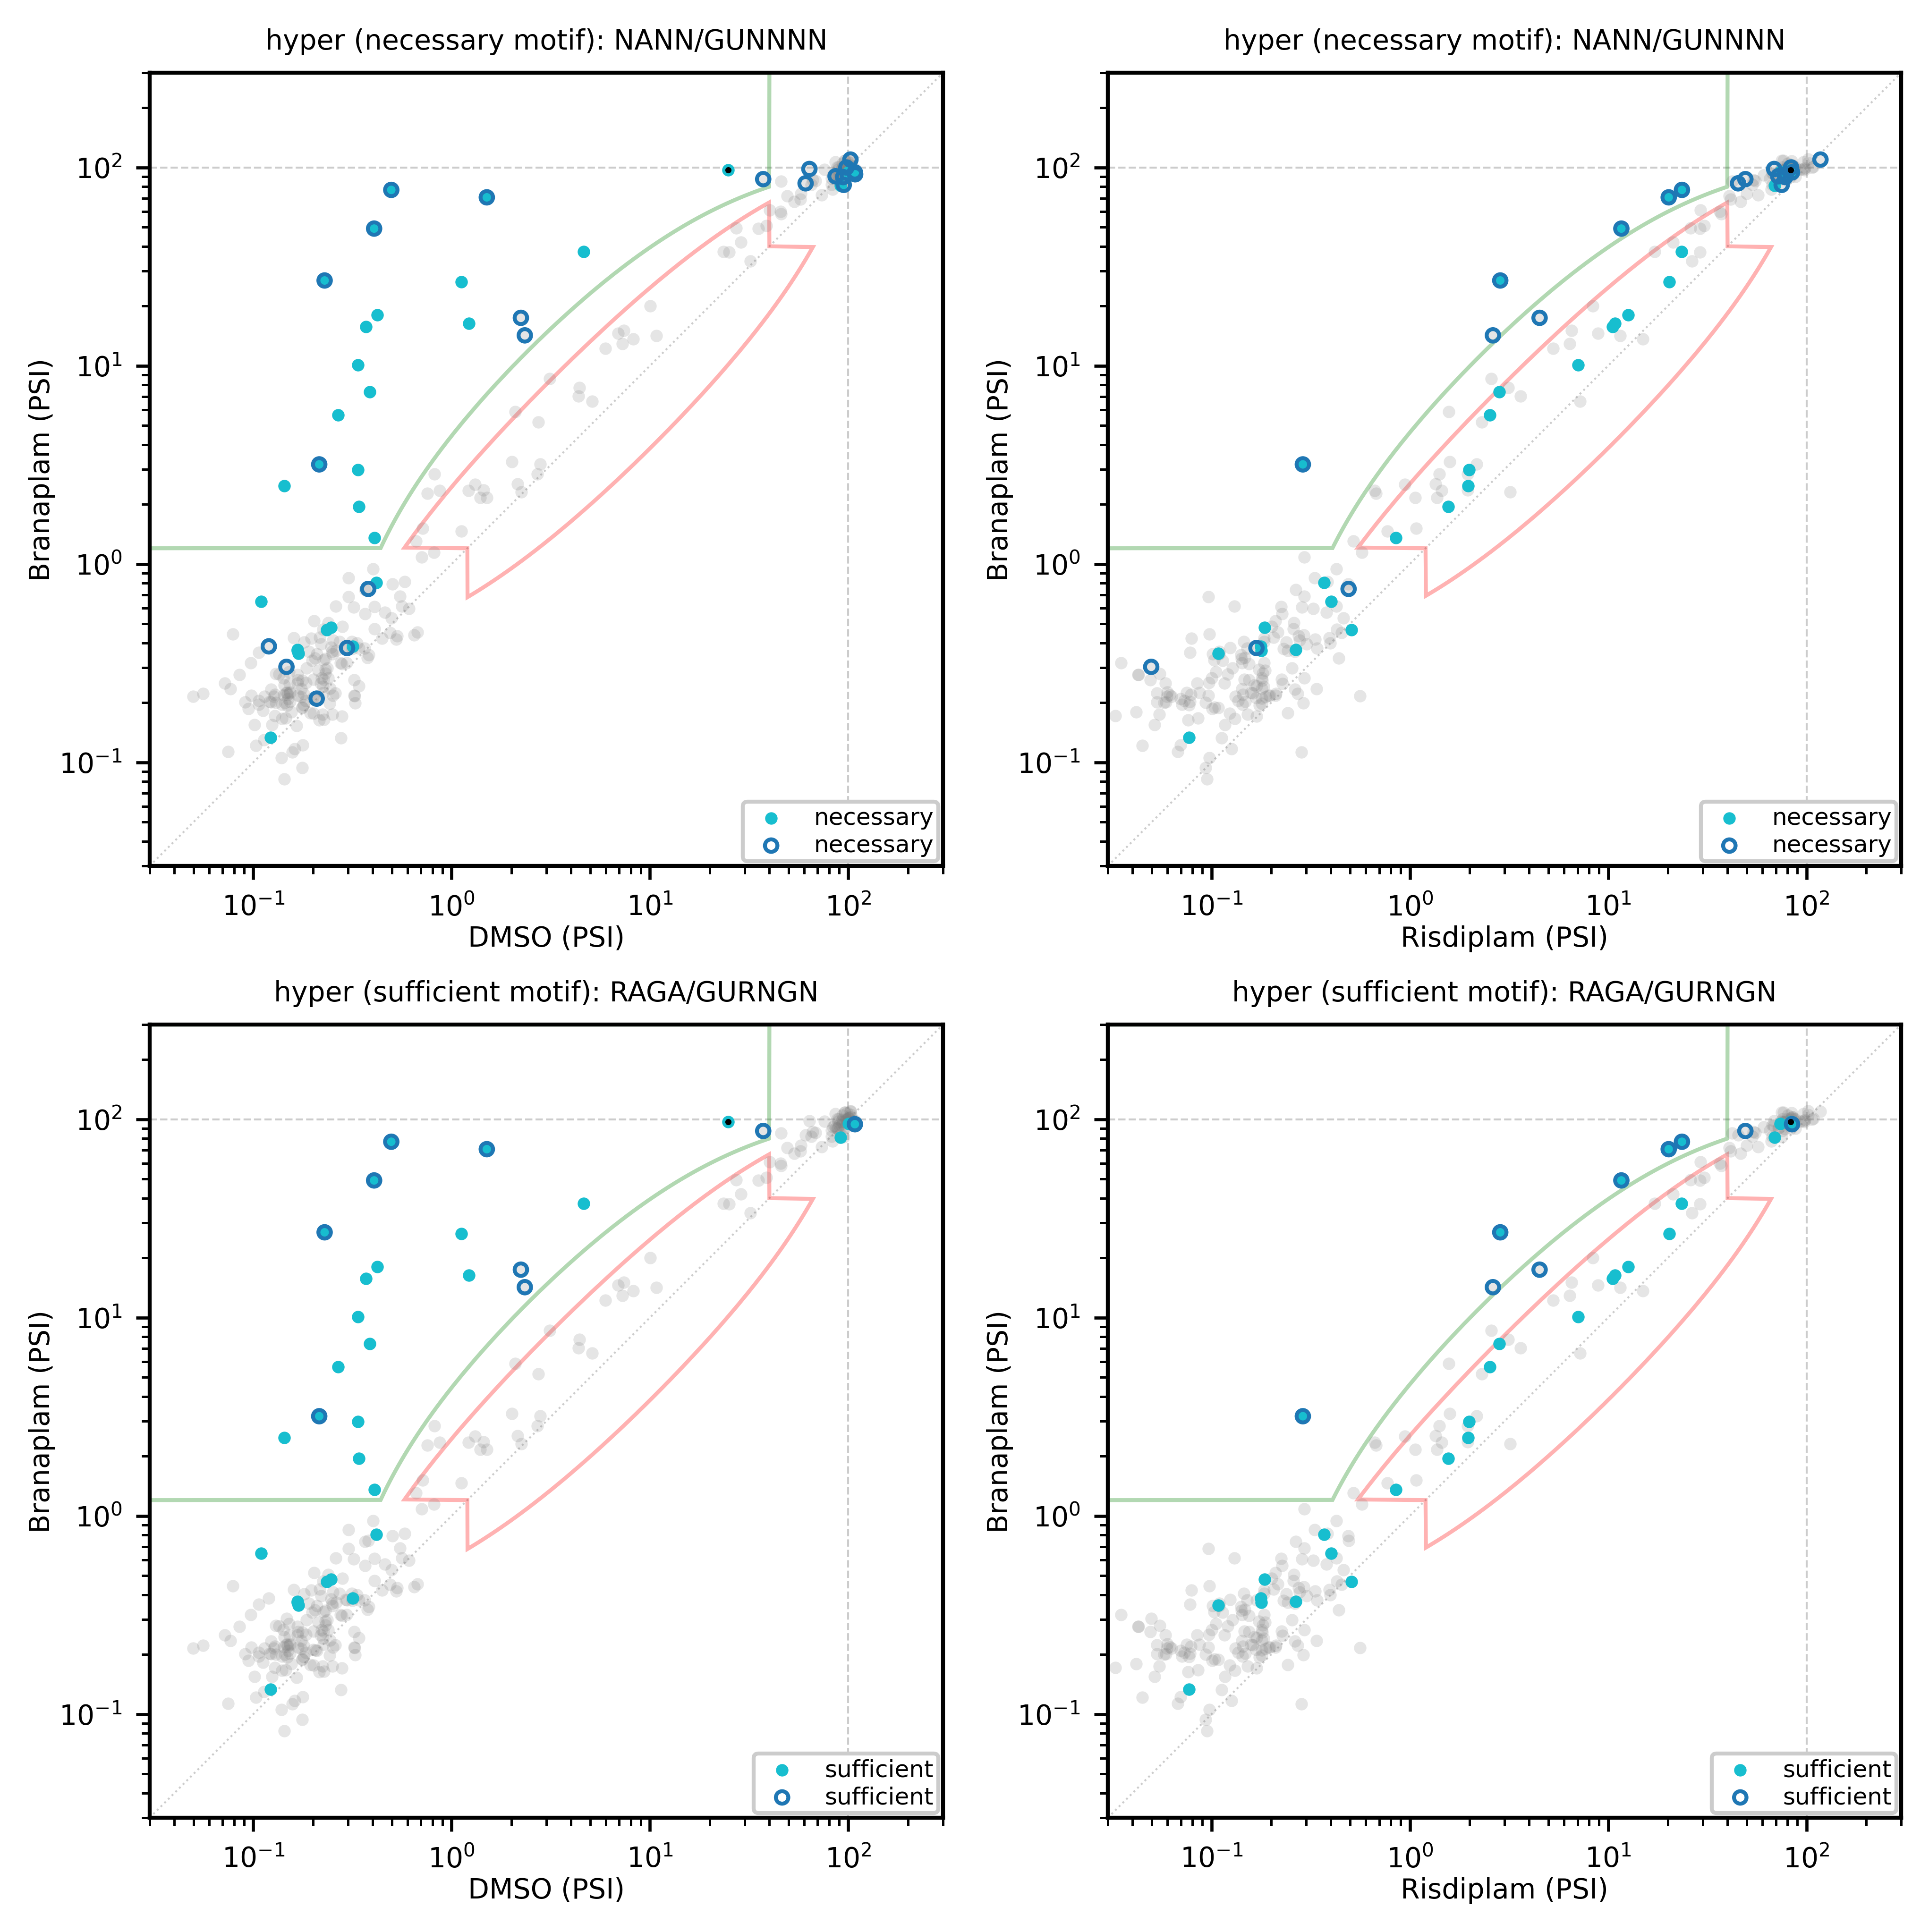

In [18]:
# Compute sufficient and necessary hyper motifs using two both bran/dmso and bran/ris data

# Set runtime params
motif_prefix = 'hyper'

# Define set of activated and non-activated sites
r_v_d_act_ix = does_polygon_contain(ris_pos_xy, zip(smn2_df['smn2_dmso'], smn2_df['smn2_rg'] )) 
r_v_d_nact_ix = does_polygon_contain(ris_neg_xy, zip(smn2_df['smn2_dmso'], smn2_df['smn2_rg'] )) 

b_v_d_act_ix = does_polygon_contain(bran_pos_xy, zip(smn2_df['smn2_dmso'], smn2_df['smn2_nvs'] )) 
b_v_d_nact_ix = does_polygon_contain(bran_neg_xy, zip(smn2_df['smn2_dmso'], smn2_df['smn2_nvs'] )) 

b_v_r_act_ix = does_polygon_contain(hyper_pos_xy, zip(smn2_df['smn2_rg'], smn2_df['smn2_nvs'] )) 
b_v_r_nact_ix = does_polygon_contain(hyper_neg_xy, zip(smn2_df['smn2_rg'], smn2_df['smn2_nvs'] )) 

# Compute inclusion and exclusion indices
in_ix = b_v_r_act_ix | (b_v_d_act_ix & (~r_v_d_act_ix))
ex_ix = b_v_r_nact_ix | b_v_d_nact_ix

# Compute indices of risdiplam sufficient motif
ris_ix = utils.motif_to_ix(motif=ris_sufficient_motif, seqs=seqs)


###
### Compute hyp motif (aka necessary motif) and risdiplam max motif (aka necessary motif)
###

# Compute maximal motif and associated stats
sufficient_motif, necessary_motif = \
    utils.get_sufficient_and_necessary_motifs(seqs, 
                                        in_ix=in_ix,
                                        ex_ix=ex_ix, 
                                        num_trials=100,
                                        verbose=True)

# FOR DEBUGGING
# necessary_motif = sufficient_motif

print(f'{motif_prefix} sufficient motif: {sufficient_motif}')
print(f'{motif_prefix} necessary motif: {necessary_motif}')
sufficient_ix = utils.motif_to_ix(sufficient_motif, seqs)
necessary_ix = utils.motif_to_ix(necessary_motif, seqs)

def draw(ax, ix, label, motif, x, y, xlabel, ylabel, pos_xy, neg_xy):
    patch_kwargs = dict(facecolor = 'none', linestyle='-', linewidth=1, alpha=.3)
    ax.add_patch(Polygon(pos_xy, edgecolor='g', **patch_kwargs))
    ax.add_patch(Polygon(neg_xy, edgecolor='r', **patch_kwargs))
    ax.scatter(x, y, alpha=.2, s=s, linewidth=0, color='C7')
    ax.scatter(x[ris_ix], y[ris_ix], alpha=1, s=s, linewidth=0, facecolor='C9', label=label)
    ax.scatter(x[ix], y[ix], alpha=1, s=s, linewidth=1, facecolor='none', edgecolor='C0', label=label)
    ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k')
    style_ax(ax, xlabel=xlabel, ylabel=ylabel)
    utils.add_click_labels(x, y, seqs, ax)
    ax.set_title(f'{motif_prefix} ({label} motif): {motif}')

# View results
fig, axs = plt.subplots(2,2,figsize=[8,8])
draw(ax=axs[0,0], ix=necessary_ix, label='necessary', motif=necessary_motif, 
     x=smn2_df['smn2_dmso'], y=smn2_df['smn2_nvs'],
     pos_xy=bran_pos_xy, neg_xy=bran_neg_xy,
     xlabel='DMSO (PSI)', ylabel='Branaplam (PSI)')
draw(ax=axs[0,1], ix=necessary_ix, label='necessary', motif=necessary_motif, 
     x=smn2_df['smn2_rg'], y=smn2_df['smn2_nvs'],
     pos_xy=hyper_pos_xy, neg_xy=hyper_neg_xy,
     xlabel='Risdiplam (PSI)', ylabel='Branaplam (PSI)')
draw(ax=axs[1,0], ix=sufficient_ix, label='sufficient', motif=sufficient_motif,
     x=smn2_df['smn2_dmso'], y=smn2_df['smn2_nvs'],
     pos_xy=bran_pos_xy, neg_xy=bran_neg_xy,
     xlabel='DMSO (PSI)', ylabel='Branaplam (PSI)')
draw(ax=axs[1,1], ix=sufficient_ix, label='sufficient', motif=sufficient_motif,
     x=smn2_df['smn2_rg'], y=smn2_df['smn2_nvs'],
     pos_xy=hyper_pos_xy, neg_xy=hyper_neg_xy,
     xlabel='Risdiplam (PSI)', ylabel='Branaplam (PSI)')

# Save
hyper_necessary_motif = necessary_motif
hyper_sufficient_motif = sufficient_motif

In [19]:
# Set indices
ris_ix = utils.motif_to_ix(ris_sufficient_motif, seqs)
print(f'ris min motif: {sum(ris_ix)}')
ris_max_ix = utils.motif_to_ix(ris_necessary_motif, seqs)
print(f'ris max motif: {sum(ris_max_ix)}')
hyper_ix = utils.motif_to_ix(hyper_sufficient_motif, seqs)
print(f'hyp min motif: {sum(hyper_ix)}')
hyper_max_ix = utils.motif_to_ix(hyper_necessary_motif, seqs)
print(f'hyp max motif: {sum(hyper_max_ix)}')

hyp_minstar_motif="NAGA/GURNGN"
hyper_minstar_ix = utils.motif_to_ix(hyp_minstar_motif, seqs)
print(f'hyp min* motif: {sum(hyper_minstar_ix)}')

wt_ix = utils.motif_to_ix(wt_motif, seqs)

ris min motif: 30
ris max motif: 81
hyp min motif: 9
hyp max motif: 22
hyp min* motif: 11


It's harder to identify a maximal activtion motif, i.e., a motif that encompases as many sequences as possible while excluding all non-activated sequences. We describe a greedy algorithm to try to identify such a sequence. 

```
old_motif = minimal_motif
motif_altered = True
while motif_altered:
    motif_altered = False
    for each position p:
        for each base b:
            if b is not already permitted at p:
                new_motif = old_motif + b allowed at p 
                if new_motif excludes all non-activated sequences:
                    old_motif = new_motif
                    motif_altered = True
```

Our greedy algorithm finds a maximal activaiton motif of `ANGA/GUHDNN`. This is the same as the minimal motif in the exonic region, but is substantially larger than the minimal motif in the intronic region. 

The fact that this motif is more specific on the exonic side than the intronic side is conistent with the specificity of risdiplam primarily being determined by interactions upstream of the 5'ss. Nice!

Figure saved to fig1DFH.pdf


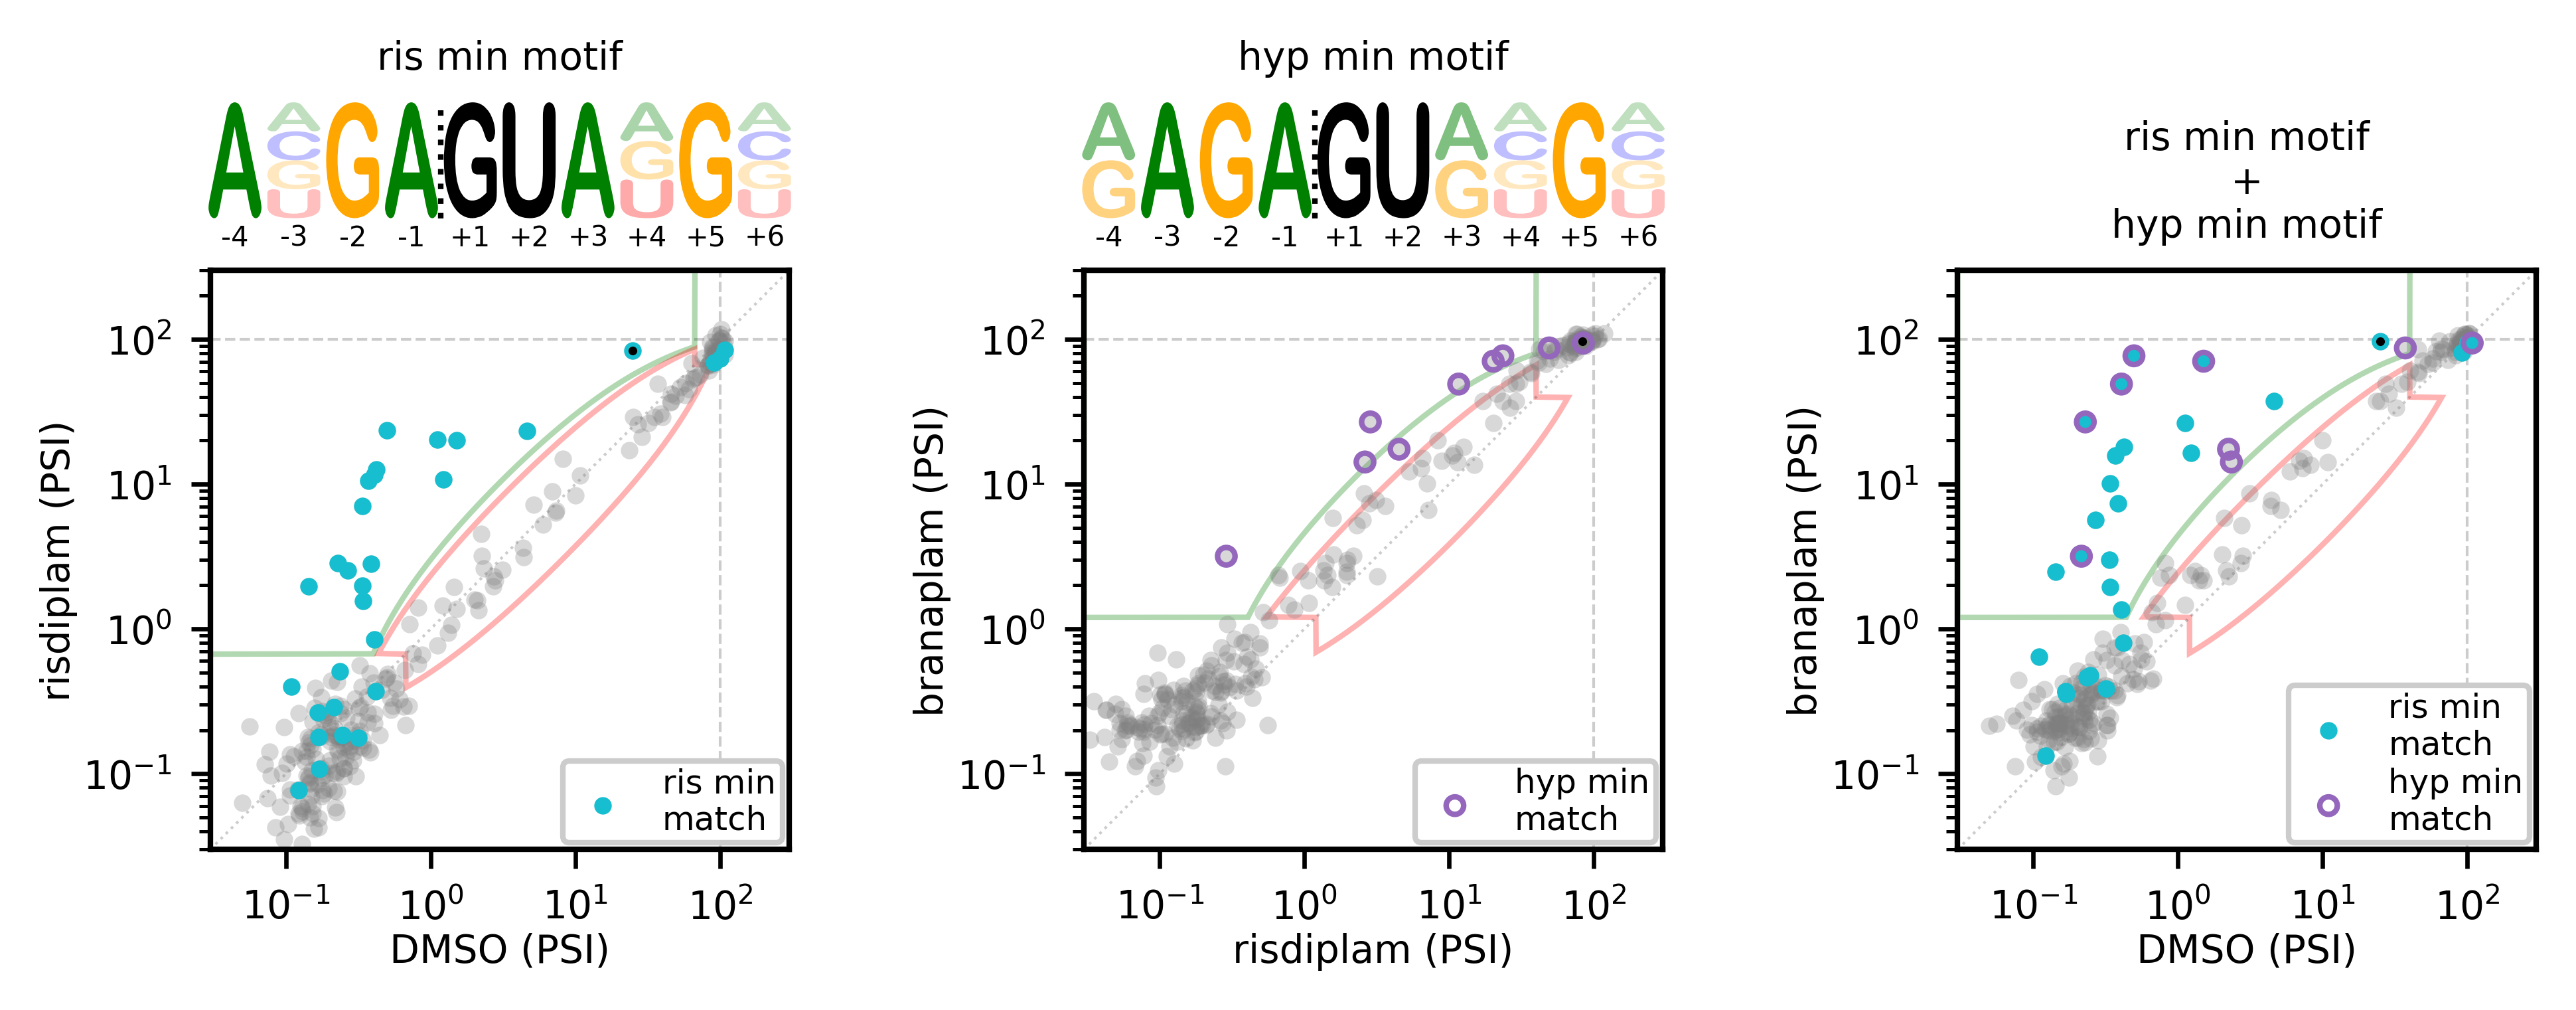

In [20]:
# Make figure
fig= plt.figure(figsize=[6.5, 2.5])
gs = GridSpec(2, 3, height_ratios=[.2,1], hspace=.15, wspace=.5, left=.08, right=.98, bottom=.13)
s=10
bulkalpha=.3

patch_kwargs = dict(facecolor = 'none', linestyle='-', linewidth=1, alpha=.3, zorder=-100)
#patch_kwargs = dict(linewidth=0, alpha=.1)

ris_min_color = 'C9'
hyp_min_color = 'C4'

ax = fig.add_subplot(gs[0,0])
draw_logo(motif=ris_sufficient_motif, 
          ax=ax,
          title='')
ax.set_title('ris min motif')
#ax.set_xticklabels([])

# Fig. 1D: 
ax = fig.add_subplot(gs[1,0])
ax.add_patch(Polygon(ris_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(ris_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_dmso, psi_ris, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_dmso[wt_ix], psi_ris[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
ax.scatter(psi_dmso[ris_ix], psi_ris[ris_ix], alpha=1, s=s, linewidth=0, 
           facecolor=ris_min_color, label='ris min\nmatch')
style_ax(ax, xlabel='DMSO (PSI)', ylabel='risdiplam (PSI)')
#utils.add_click_labels(psi_dmso, psi_ris, seqs, ax)

ax = fig.add_subplot(gs[0,1])
draw_logo(motif=hyper_sufficient_motif, 
          ax=ax,
          title='')
ax.set_title('hyp min motif')
#ax.set_xticklabels([])

# Fig. 1F: 
ax = fig.add_subplot(gs[1,1])
ax.add_patch(Polygon(hyper_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(hyper_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_ris, psi_bran, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_ris[wt_ix], psi_bran[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
#ax.scatter(psi_ris[ris_max_ix], psi_bran[ris_max_ix], alpha=1, s=s, linewidth=0, 
#           facecolor=ris_max_color, label='ris max')
ax.scatter(psi_ris[hyper_ix], psi_bran[hyper_ix], alpha=1, s=s, linewidth=1, 
           edgecolor=hyp_min_color, facecolor='none', label='hyp min\nmatch')
style_ax(ax, xlabel='risdiplam (PSI)', ylabel='branaplam (PSI)')
#utils.add_click_labels(psi_ris, psi_bran, seqs, ax)
#ax.get_legend().remove()

# Fig. 1H: 
ax = fig.add_subplot(gs[1,2])
ax.add_patch(Polygon(bran_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(bran_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_dmso, psi_bran, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_dmso[wt_ix], psi_bran[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
ax.scatter(psi_dmso[ris_ix], psi_bran[ris_ix], alpha=1, s=s, linewidth=0, 
           facecolor=ris_min_color, label='ris min\nmatch')
ax.scatter(psi_dmso[hyper_ix], psi_bran[hyper_ix], alpha=1, s=s, linewidth=1, 
           edgecolor=hyp_min_color, facecolor='none', label='hyp min\nmatch')
style_ax(ax, xlabel='DMSO (PSI)', ylabel='branaplam (PSI)')
#utils.add_click_labels(psi_dmso, psi_bran, seqs, ax)
#ax.get_legend().remove()
ax.set_title('ris min motif\n+\nhyp min motif')


# Save figure
#plt.tight_layout(w_pad=2, h_pad=2)
fig_name = 'fig1DFH.pdf'
fig.savefig(fig_name)
print(f'Figure saved to {fig_name}')


Figure saved to fig1EGI.pdf


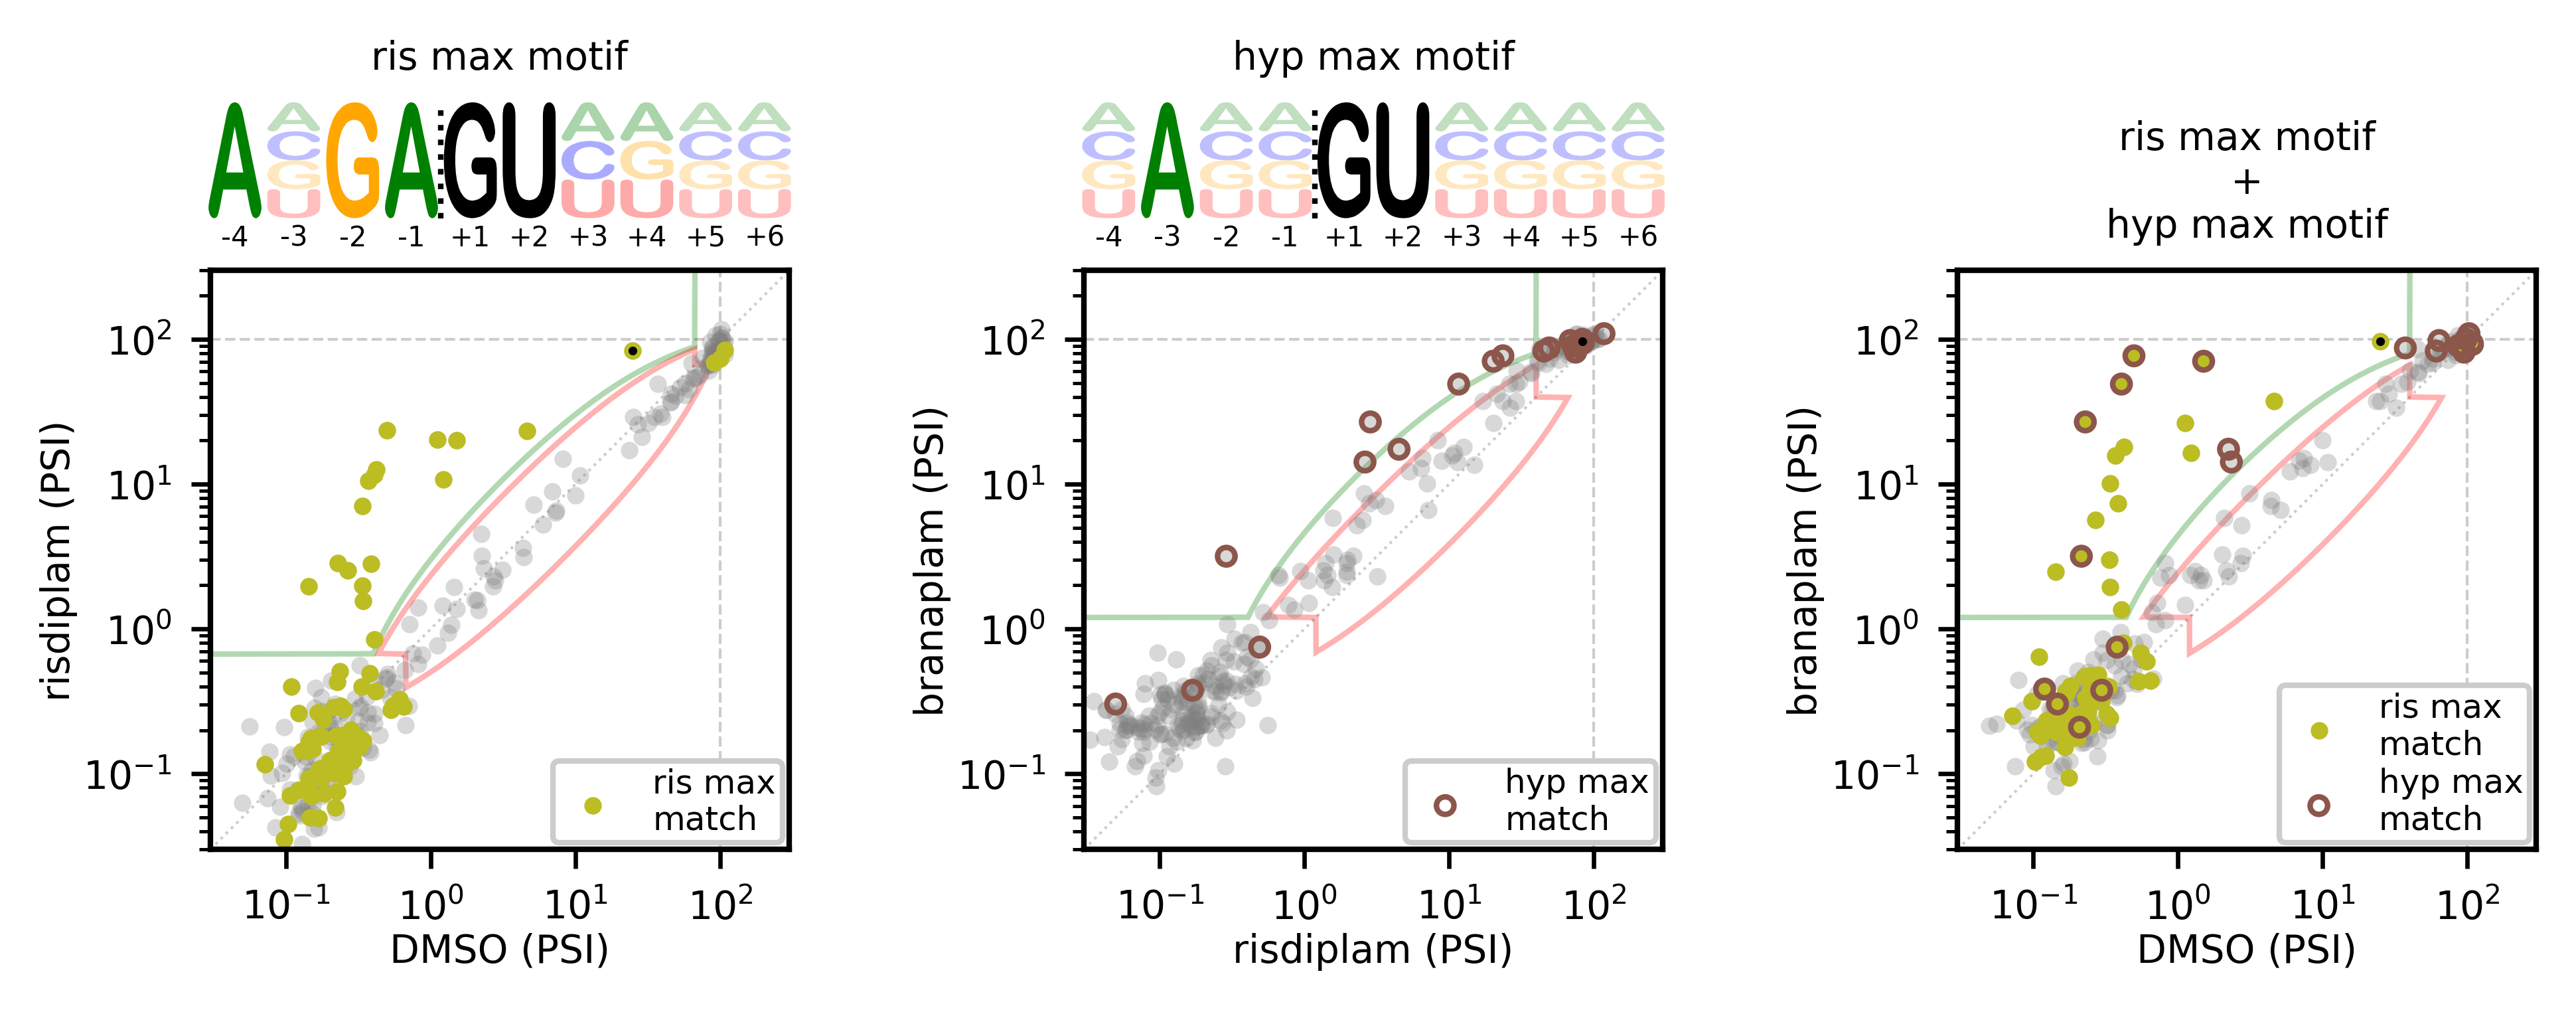

In [21]:
# Make figure
fig= plt.figure(figsize=[6.5, 2.5])
gs = GridSpec(2, 3, height_ratios=[.2,1], hspace=.15, wspace=.5, left=.08, right=.98, bottom=.13)
s=10
bulkalpha=.3

patch_kwargs = dict(facecolor = 'none', linestyle='-', linewidth=1, alpha=.3, zorder=-100)
#patch_kwargs = dict(linewidth=0, alpha=.1)

ris_max_color = 'C8'
hyp_max_color = 'C5'

ax = fig.add_subplot(gs[0,0])
draw_logo(motif=ris_necessary_motif, 
          ax=ax,
          title='')
ax.set_title('ris max motif')
#ax.set_xticklabels([])

# Fig. 1D: 
ax = fig.add_subplot(gs[1,0])
ax.add_patch(Polygon(ris_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(ris_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_dmso, psi_ris, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_dmso[wt_ix], psi_ris[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
ax.scatter(psi_dmso[ris_max_ix], psi_ris[ris_max_ix], alpha=1, s=s, linewidth=0, 
           facecolor=ris_max_color, label='ris max\nmatch')
style_ax(ax, xlabel='DMSO (PSI)', ylabel='risdiplam (PSI)')
#utils.add_click_labels(psi_dmso, psi_ris, seqs, ax)

ax = fig.add_subplot(gs[0,1])
draw_logo(motif=hyper_necessary_motif, 
          ax=ax,
          title='')
ax.set_title('hyp max motif')
#ax.set_xticklabels([])

# Fig. 1E: 
ax = fig.add_subplot(gs[1,1])
ax.add_patch(Polygon(hyper_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(hyper_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_ris, psi_bran, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_ris[wt_ix], psi_bran[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
#ax.scatter(psi_ris[ris_max_ix], psi_bran[ris_max_ix], alpha=1, s=s, linewidth=0, 
#           facecolor=ris_max_color, label='ris max')
ax.scatter(psi_ris[hyper_max_ix], psi_bran[hyper_max_ix], alpha=1, s=s, linewidth=1, 
           edgecolor=hyp_max_color, facecolor='none', label='hyp max\nmatch')
style_ax(ax, xlabel='risdiplam (PSI)', ylabel='branaplam (PSI)')
#utils.add_click_labels(psi_ris, psi_bran, seqs, ax)
#ax.get_legend().remove()

# Fig. 1F: 
ax = fig.add_subplot(gs[1,2])
ax.add_patch(Polygon(bran_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(bran_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_dmso, psi_bran, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_dmso[wt_ix], psi_bran[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
ax.scatter(psi_dmso[ris_max_ix], psi_bran[ris_max_ix], alpha=1, s=s, linewidth=0, 
           facecolor=ris_max_color, label='ris max\nmatch')
ax.scatter(psi_dmso[hyper_max_ix], psi_bran[hyper_max_ix], alpha=1, s=s, linewidth=1, 
           edgecolor=hyp_max_color, facecolor='none', label='hyp max\nmatch')
style_ax(ax, xlabel='DMSO (PSI)', ylabel='branaplam (PSI)')
#utils.add_click_labels(psi_dmso, psi_bran, seqs, ax)
#ax.get_legend().remove()
ax.set_title('ris max motif\n+\nhyp max motif')

# Save figure
#plt.tight_layout(w_pad=2, h_pad=2)
fig_name = 'fig1EGI.pdf'
fig.savefig(fig_name)
print(f'Figure saved to {fig_name}')


Figure saved to figS8.pdf


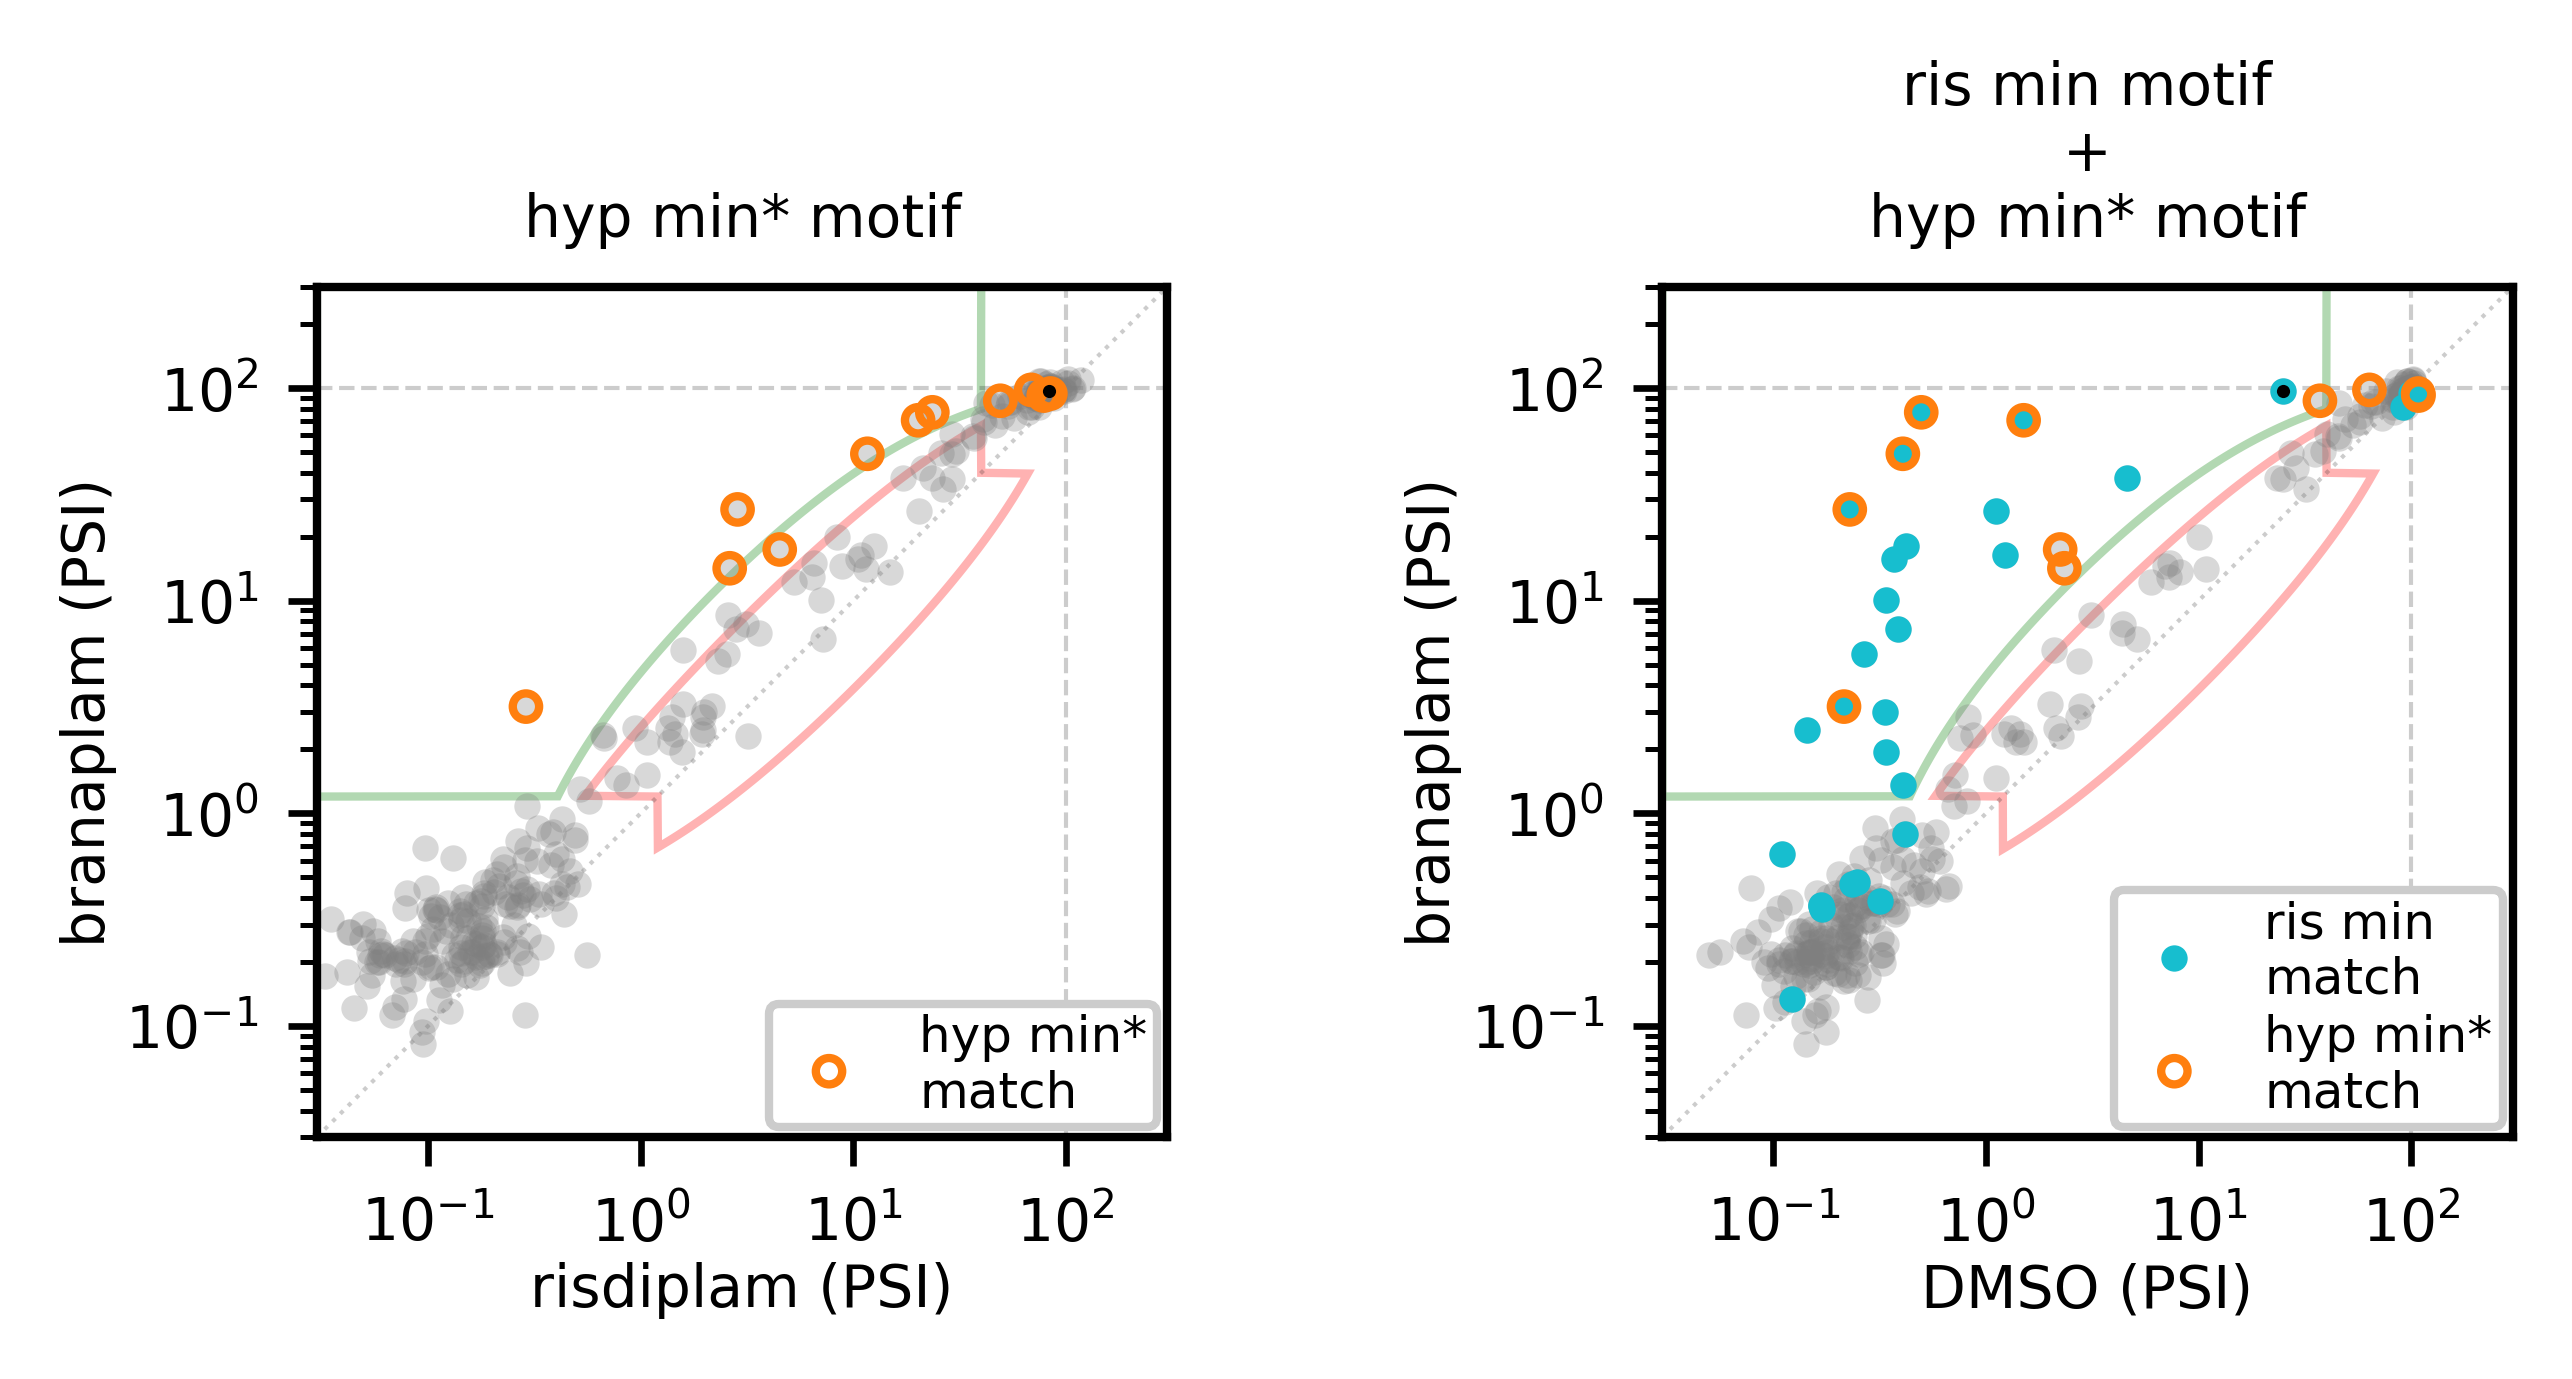

In [22]:
# Make figure
fig, axs = plt.subplots(1,2,figsize=[4.5, 2.2])
s=10
bulkalpha=.3

patch_kwargs = dict(facecolor = 'none', linestyle='-', linewidth=1, alpha=.3, zorder=-100)
#patch_kwargs = dict(linewidth=0, alpha=.1)

ris_min_color = 'C9'
hyp_minstar_color = 'C1'

# Panel A
ax = axs[0]
ax.add_patch(Polygon(hyper_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(hyper_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_ris, psi_bran, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_ris[hyper_minstar_ix], psi_bran[hyper_minstar_ix], alpha=1, s=s, linewidth=1, 
           edgecolor=hyp_minstar_color, facecolor='none', label='hyp min*\nmatch')
ax.scatter(psi_ris[wt_ix], psi_bran[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
style_ax(ax, xlabel='risdiplam (PSI)', ylabel='branaplam (PSI)')
#utils.add_click_labels(psi_ris, psi_bran, seqs, ax)
#ax.get_legend().remove()
ax.set_title('hyp min* motif')

# Panel B
ax = axs[1]
ax.add_patch(Polygon(bran_pos_xy, edgecolor='g', **patch_kwargs))
ax.add_patch(Polygon(bran_neg_xy, edgecolor='r', **patch_kwargs))
ax.scatter(psi_dmso, psi_bran, alpha=bulkalpha, s=s, linewidth=0, color='C7')
ax.scatter(psi_dmso[ris_ix], psi_bran[ris_ix], alpha=1, s=s, linewidth=0, 
           facecolor=ris_min_color, label='ris min\nmatch')
ax.scatter(psi_dmso[hyper_minstar_ix], psi_bran[hyper_minstar_ix], alpha=1, s=s, linewidth=1, 
           edgecolor=hyp_minstar_color, facecolor='none', label='hyp min*\nmatch')
ax.scatter(psi_dmso[wt_ix], psi_bran[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', zorder=100)
style_ax(ax, xlabel='DMSO (PSI)', ylabel='branaplam (PSI)')
#utils.add_click_labels(psi_dmso, psi_bran, seqs, ax)
#ax.get_legend().remove()
ax.set_title('ris min motif\n+\nhyp min* motif')

# Save figure
plt.tight_layout(w_pad=2, h_pad=2)
fig_name = 'figS8.pdf'
fig.savefig(fig_name)
print(f'Figure saved to {fig_name}')


In [23]:
# # Draw hyp min* motif
# hyp_min_star_motif = 'NAGA/GURNGN'

# # Make figure
# fig, ax = plt.subplots(1,1,figsize=[2.3, .9])
# draw_logo(motif=hyp_min_star_motif, 
#           ax=ax,
#           title='')
# ax.set_title('hyp min* motif', pad=5)
# ax.tick_params(length=0, labelsize=7, pad=1)
    
# # Save figure
# plt.tight_layout()
# fig_name = 'fig2F.pdf'
# fig.savefig(fig_name)
# print(f'Figure saved to {fig_name}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Figure saved to figS2.pdf


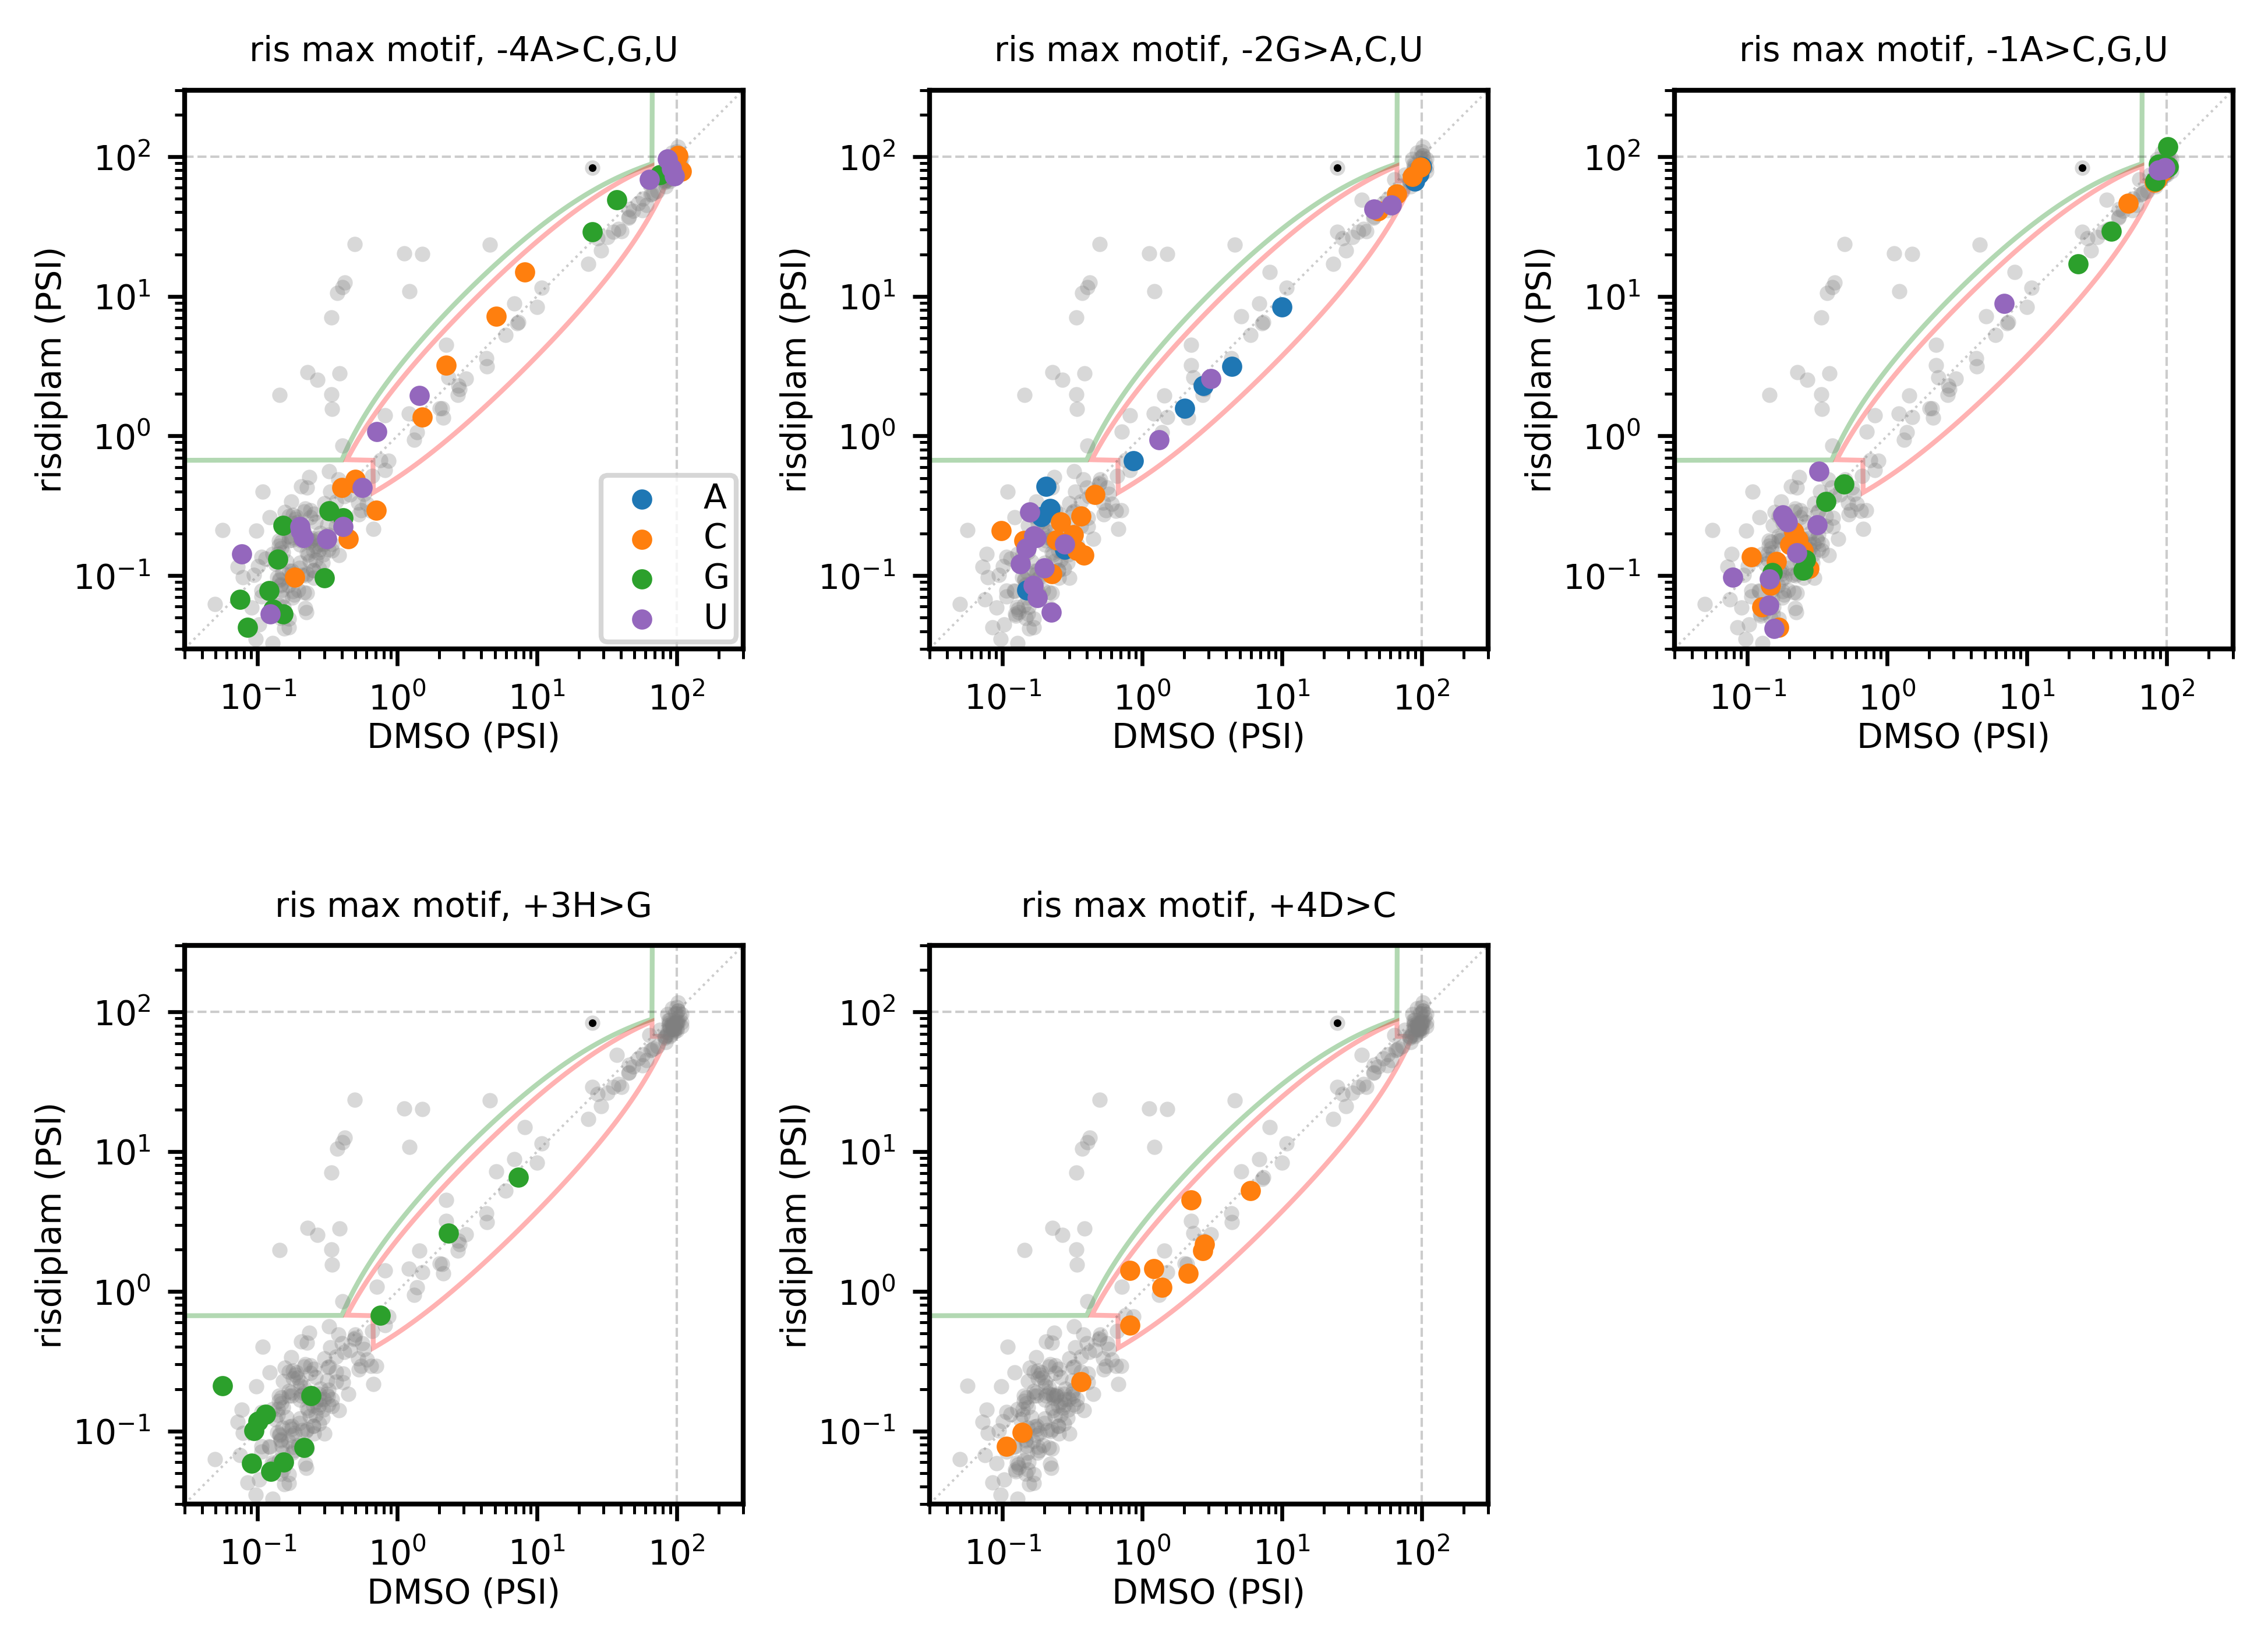

In [24]:
# Plot mutations away from the necessary motif
lib_motif = 'NNNN/GUNNNN'
hit_motif = ris_necessary_motif # ris max motif
color_dict = {'A':'C0', 'C':'C1', 'G':'C2', 'U':'C4'}
s=10

# Set x and y
x = psi_dmso
y = psi_ris

# Create dict of positions and bases to mutate to
pos_to_nt_pair = {}

# Iterate over positions
info_to_plot = []
for i in range(len(ris_necessary_motif)):
    
    # If motif nt at position is not equal to that in the library
    if hit_motif[i] != lib_motif[i]:
        pos = i-4
        motif_iupac = hit_motif[i]
        motif_bs = utils.iupac_nt_to_list(hit_motif[i])
        mut_bs = [b for b in 'ACGU' if b not in motif_bs]
        info_to_plot.append([pos, motif_iupac, mut_bs])

# Raw risdiplam vs DMSO
fig, axs = plt.subplots(2,3,figsize=[6.5,5], sharex=False, sharey=False)
axs = axs.ravel()

for i, (pos, motif_iupac, mut_bs) in enumerate(info_to_plot):
    
    #  Set ax
    ax = axs[i]
    
    # Show positive and negative regions
    ax.add_patch(Polygon(ris_pos_xy, edgecolor = 'g', **patch_kwargs))
    ax.add_patch(Polygon(ris_neg_xy, edgecolor = 'r', **patch_kwargs))
    
    # Plot non-null and wt
    ax.scatter(x[~null_ix], y[~null_ix], alpha=bulkalpha, s=s, linewidth=0, color='C7')
    ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k')
    
    # Plot variants
    for b in mut_bs:
        test_motif = list(hit_motif)
        test_motif[pos+4] = b
        test_motif = ''.join(test_motif)
        test_re = utils.iupac_to_regex(test_motif)
        test_ix = np.array([bool(re.match(test_re, seq)) for seq in smn2_df.index.values])
        ax.scatter(x[test_ix], y[test_ix], alpha=1,  linewidth=1, s=s, color=color_dict[b])
        
    if i==0:
        for b in 'ACGU':
            ax.scatter([1000],[1000], alpha=1,  linewidth=1, s=s, color=color_dict[b], label=b)
    
    #  Style ax
    style_ax(ax, xlabel='DMSO (PSI)', ylabel='risdiplam (PSI)')
    utils.add_click_labels(x, y, seqs, ax, ix=~null_ix)
    ax.set_title(f'ris max motif, {pos:+d}{motif_iupac}>{",".join(mut_bs)}')
    ax.legend(loc='lower right')
    
    if i!=0:
        ax.get_legend().remove()
    
axs[-1].axis('off')
        
# Save figure
plt.tight_layout()
fig_name = 'figS2.pdf'
fig.savefig(fig_name)
print(f'Figure saved to {fig_name}')

Figure saved to figS4.pdf


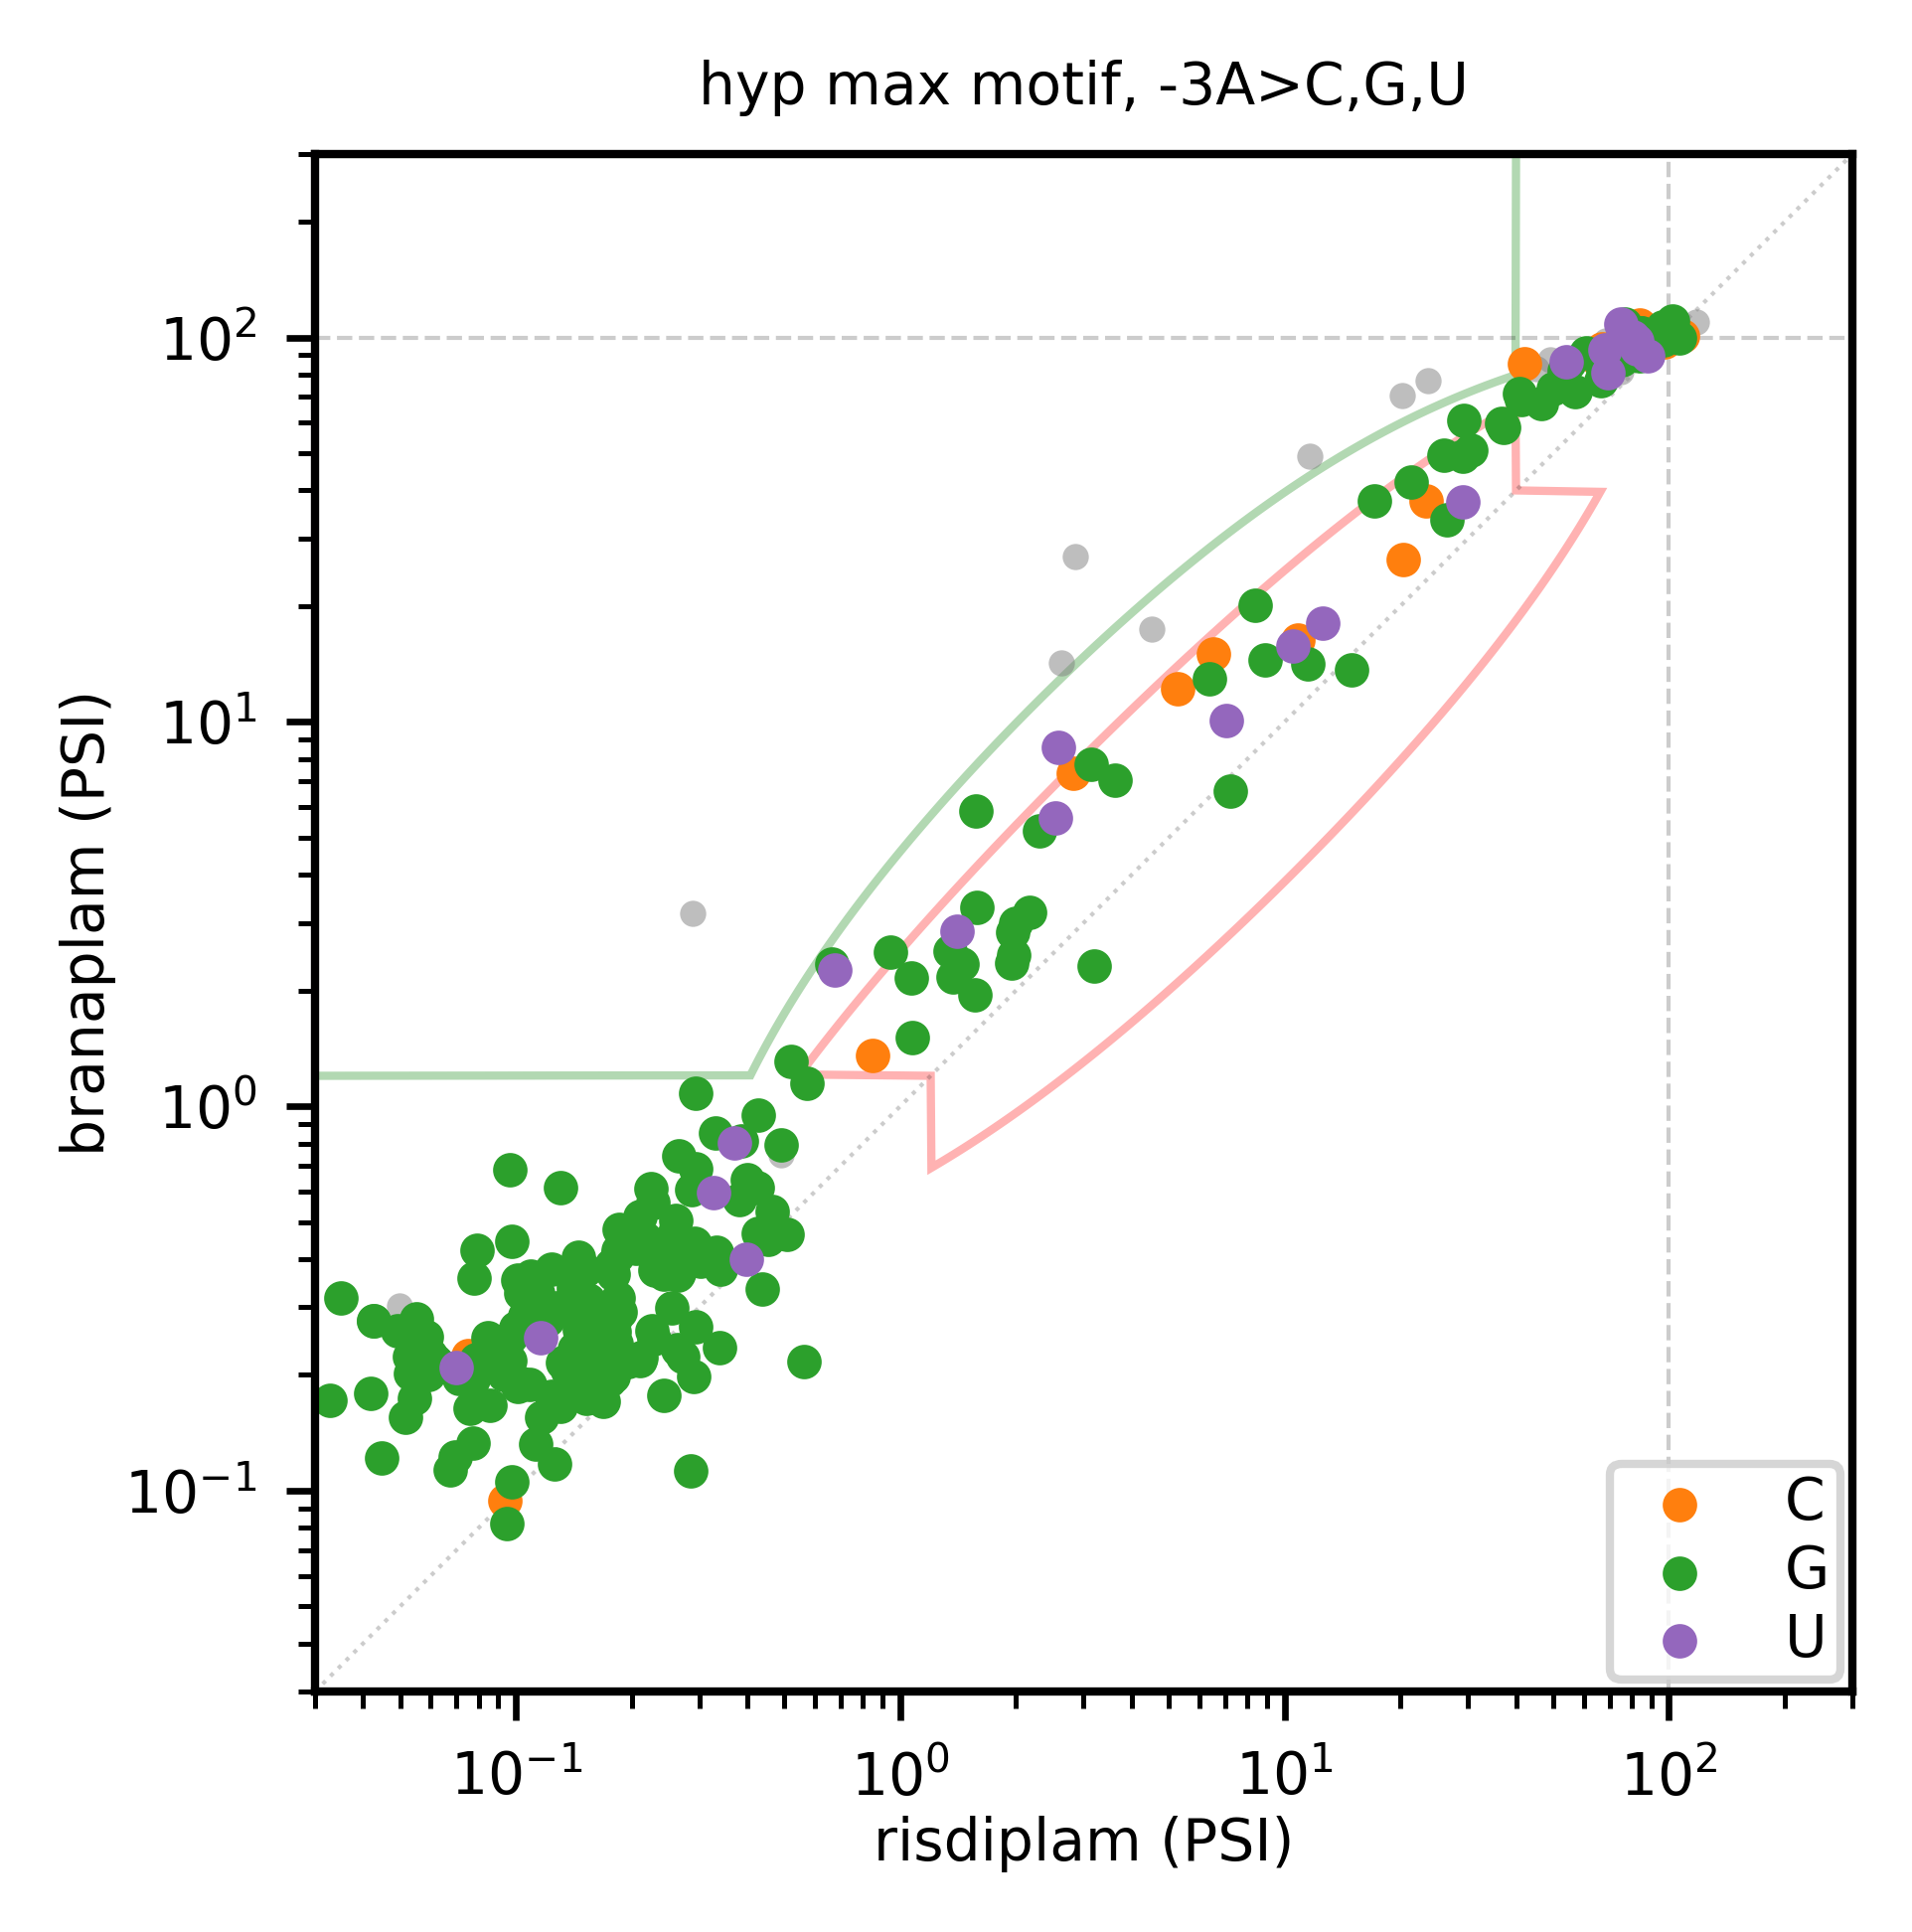

In [25]:
# Plot mutations away from the maximal motif
lib_motif = 'NNNN/GUNNNN'
hit_motif = hyper_necessary_motif  # hyp max motif
color_dict = {'A':'C0', 'C':'C1', 'G':'C2', 'U':'C4'}
s=10

# Set x and y
x = psi_ris
y = psi_bran

# Create dict of positions and bases to mutate to
pos_to_nt_pair = {}

# Iterate over positions
info_to_plot = []
for i in range(len(ris_necessary_motif)):
    
    # If motif nt at position is not equal to that in the library
    if hit_motif[i] != lib_motif[i]:
        pos = i-4
        motif_iupac = hit_motif[i]
        motif_bs = utils.iupac_nt_to_list(hit_motif[i])
        mut_bs = [b for b in 'ACGU' if b not in motif_bs]
        info_to_plot.append([pos, motif_iupac, mut_bs])

# Raw risdiplam vs DMSO
fig, ax = plt.subplots(1,1,figsize=[3.25,3.25], sharex=False, sharey=False)
#axs = axs.ravel()

for i, (pos, motif_iupac, mut_bs) in enumerate(info_to_plot):
    
    #  Set ax
#     ax = axs[i]
    
    # Show positive and negative regions
    ax.add_patch(Polygon(hyper_pos_xy, edgecolor = 'g', **patch_kwargs))
    ax.add_patch(Polygon(hyper_neg_xy, edgecolor = 'r', **patch_kwargs))
    
    # Plot non-null and wt
    ax.scatter(x[~null_ix], y[~null_ix], alpha=.5, s=s, linewidth=0, color='C7')
    ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k')
    
    # Plot variants
    for b in mut_bs:
        test_motif = list(hit_motif)
        test_motif[pos+4] = b
        test_motif = ''.join(test_motif)
        test_re = utils.iupac_to_regex(test_motif)
        test_ix = np.array([bool(re.match(test_re, seq)) for seq in smn2_df.index.values])
        ix = test_ix
        ax.scatter(x[ix], y[ix], alpha=1, s=s, linewidth=1, color=color_dict[b], label=b)
    
    #  Style ax
    style_ax(ax, xlabel='risdiplam (PSI)', ylabel='branaplam (PSI)')
    utils.add_click_labels(x, y, seqs, ax, ix=~null_ix)
    ax.set_title(f'hyp max motif, {pos:+d}{motif_iupac}>{",".join(mut_bs)}')
    ax.legend(loc='lower right')
            
# Save figure
plt.tight_layout()
fig_name = 'figS4.pdf'
fig.savefig(fig_name)
print(f'Figure saved to {fig_name}')

In [26]:
# Print and save key results
print(f'ris_sufficient_motif="{ris_sufficient_motif}"')
print(f'ris_necessary_motif="{ris_necessary_motif}"')
print(f'hyper_sufficient_motif="{hyper_sufficient_motif}"')
print(f'hyper_necessary_motif="{hyper_necessary_motif}"')

ris_sufficient_motif="ANGA/GUADGN"
ris_necessary_motif="ANGA/GUHDNN"
hyper_sufficient_motif="RAGA/GURNGN"
hyper_necessary_motif="NANN/GUNNNN"


## Done!